In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from tqdm import tqdm
import argparse
from functools import partial
from torchvision.utils import make_grid
from shell.utils.oodloss import OODSeparationLoss
from pythresh.thresholds.dsn import DSN
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict

from shell.fleet.network import *
logging.basicConfig(level=logging.INFO)

In [3]:

# modmod
# experiment_folder = "combined_data_experiment_results"
# experiment_name = "leep_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True"
# dataset = "combined"
# algo = "modular"

# topology
# experiment_folder = "new_topology_experiment_results"
# experiment_name = os.path.join("modmod", "topology_server_edge_drop_0.0")
# dataset = "cifar100"
# algo = "modular"

experiment_folder = "experiment_results"
experiment_name = "jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True"
dataset = "cifar100"
algo = "modular"


use_contrastive = False
num_trains_per_class = 64 if dataset != "cifar100" else 256
seed = 0
num_tasks = 10
parallel = False




In [4]:
def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
    # cfg.sharing_strategy["sync_base"] = False


    cfg.sharing_strategy = DictConfig({
        "name": "modmod",
        "num_coms_per_round": 2,
        "module_selection": "gt_most_similar",
        "pre_or_post_comm": "pre",
        "ranker": "label",
        "module_select": "tryout",
        "num_shared_module": 1,
        "num_tryout_epochs": 10,
        "max_num_modules_tryout": 1,
        "sync_base":True,
    })
    return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

In [5]:
save_dir = get_save_dir(experiment_folder, experiment_name,
                        dataset, algo, num_trains_per_class, use_contrastive, seed)

fleet = setup_fleet(save_dir, task_id=None, parallel=False, modify_cfg=modify_cfg)
fleet.change_save_dir('combined_dataset_engineering_experiment_results')
set_color(fleet)
communication = get_communication(fleet)
edge_widths = set_weight(fleet, communication)



{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'cifar100', 'num_tasks': 20, 'num_classes_per_task': 5, 'with_replacement': False, 'num_trains_per_class': 256, 'num_vals_per_class': -1, 'remap_labels': True}, 'net': {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5, 'no_sparse_basis': True}, 'sharing_strategy': {'name': 'modmod', 'num_coms_per_round': 2, 'module_selection': 'gt_most_similar', 'pre_or_post_comm': 'pre', 'opt_with_random': False, 'comm_freq': 100, 'sync_base': True, 'freeze_candidate_module': False, 'transfer_decoder': True, 'transfer_structure': True}, 'seed': 0, 'algo': 'modular', 'job_name': 'cifar100_modular_numtrain_256', 'num_agents': 8, 'root_save_dir': 'experiment_results/jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True

INFO:root:Class sequence: [97 66 33 19 34  3 12  2 13 92 80  5 27 60 36 11  9 25 31 87 58 44 94 95
 64 61 62 86 79 98 93 51 22 59 26 37 83 73 78  1 30 55 85 47 41 20 63 43
 90 88 21 40 15 75  4  0 52 23 35 53 84 69 16 10 71 81  6 91 56 76 38 50
 57 74 49 18 24 39 48 99  8 65 89 67 54 32 42 14 68 45 96 77 46 28 72 17
 29 82  7 70]
INFO:root:task 0 :(1280, 3, 32, 32) (469, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32, 32) (527, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 2 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 3 :(1280, 3, 32, 32) (532, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 4 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 5 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 6 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 7 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 8 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)


labels: [97 66 33 19 34  3 12  2 13 92 80  5 27 60 36 11  9 25 31 87 58 44 94 95
 64 61 62 86 79 98 93 51 22 59 26 37 83 73 78  1 30 55 85 47 41 20 63 43
 90 88 21 40 15 75  4  0 52 23 35 53 84 69 16 10 71 81  6 91 56 76 38 50
 57 74 49 18 24 39 48 99  8 65 89 67 54 32 42 14 68 45 96 77 46 28 72 17
 29 82  7 70]


INFO:root:task 9 :(1280, 3, 32, 32) (490, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 10 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (490, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (504, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (475, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (471, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (532, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [13 55 29 67 64 47 58 19 30 38 15 16 34 35 73 96 25 89 63  5 44 21 28 60
 80 86 36 95 83 40  2 24 37 61 62 57 53 79 27 82 65  4 22 45 78 33 32  9
 90 56 46 48  7 59 41 93 98 69 51 74 68 72 71 39

labels: [13 55 29 67 64 47 58 19 30 38 15 16 34 35 73 96 25 89 63  5 44 21 28 60
 80 86 36 95 83 40  2 24 37 61 62 57 53 79 27 82 65  4 22 45 78 33 32  9
 90 56 46 48  7 59 41 93 98 69 51 74 68 72 71 39 54 18 91 76 70 11 10 99
 77 52 87 31  6  1 84 43 85 42 12 94 26 88 17 49 75 92  8 97 66 50  0 23
 20 81 14  3]


INFO:root:task 10 :(1280, 3, 32, 32) (514, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (474, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (474, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (474, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (485, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (537, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [11 37 44 67 45 66 96  1 88  4  2 84 22 50 29 28 41 82 25  5  9 77 13 17
 48 76 93 81 73 91 14 94 24 32 75 19 71 10 55 63 58 33 83 18 21  6 26 52
 68  3 78 57 80 15 59 99 86 95 92 30  0  8 53 49 35 31 16 61 60 47 98 40
 46 34 97 56 12 74 51 43 27 70 20 90 64 36 72

labels: [11 37 44 67 45 66 96  1 88  4  2 84 22 50 29 28 41 82 25  5  9 77 13 17
 48 76 93 81 73 91 14 94 24 32 75 19 71 10 55 63 58 33 83 18 21  6 26 52
 68  3 78 57 80 15 59 99 86 95 92 30  0  8 53 49 35 31 16 61 60 47 98 40
 46 34 97 56 12 74 51 43 27 70 20 90 64 36 72 65 62 42 69  7 89 38 39 79
 85 23 87 54]


INFO:root:task 11 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (460, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (529, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [63  2 24 65 38 56 94 61 75 55 25 96 86 32 11 64 30 67 80 27 41 52 20  0
 97 50 40 43 36 17 33 34 53 29 44 16 84 15 90 62 18 51 79 88 95 49 35 76
 59 31  8 14 68  9 71  6 73  5 66 28 72  1 13 93 60 12 78 26 98  4 46 39
  3 48 37 69 70 87 83 91 42 47 45 81 92 19 74 89 22 10 82 23 77 85 99 58
 21 54  7 57]
INFO:root:task 0 :(1280, 3, 3

labels: [63  2 24 65 38 56 94 61 75 55 25 96 86 32 11 64 30 67 80 27 41 52 20  0
 97 50 40 43 36 17 33 34 53 29 44 16 84 15 90 62 18 51 79 88 95 49 35 76
 59 31  8 14 68  9 71  6 73  5 66 28 72  1 13 93 60 12 78 26 98  4 46 39
  3 48 37 69 70 87 83 91 42 47 45 81 92 19 74 89 22 10 82 23 77 85 99 58
 21 54  7 57]


INFO:root:task 10 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (490, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (504, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (555, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (471, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (455, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [ 6 30 52 18 83 48  1 71 97 53  5 31 72 49 11 40 59 27 14 75 63 41 93 74
 44  7 77 87 33 51 28 43 24 69 54 42 19 17 68  8  3 73 46 22  4 92 76 89
 78 56 61 91 50 67 45  0 36 99 79 64 96 21 29 32 98 70 88 57 39 47 12 81
 10  2 25 37 60 20 16 86  9 62 55 58 94 23 13

labels: [ 6 30 52 18 83 48  1 71 97 53  5 31 72 49 11 40 59 27 14 75 63 41 93 74
 44  7 77 87 33 51 28 43 24 69 54 42 19 17 68  8  3 73 46 22  4 92 76 89
 78 56 61 91 50 67 45  0 36 99 79 64 96 21 29 32 98 70 88 57 39 47 12 81
 10  2 25 37 60 20 16 86  9 62 55 58 94 23 13 35 90 80 34 84 15 95 82 85
 65 26 38 66]


INFO:root:task 10 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (512, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (513, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (505, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (474, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (525, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (493, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (479, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [31  6 72  5 12 20 71 70 26 66 52 42  2 47 56 86 21 33 76 16 80 98 97 79
 10 84 55  8 23 83 77 68 93 25 27 90 24 43 91 40 96 28  7 49 35 15 48 50
 18 53  0 92 58 34 95 32  9 64 11 60 73 14 39 19 51 88 99 29 13 87 41 69
 37  4  3 63 67 65 59 62 54 36 61 94 89 75 74

labels: [31  6 72  5 12 20 71 70 26 66 52 42  2 47 56 86 21 33 76 16 80 98 97 79
 10 84 55  8 23 83 77 68 93 25 27 90 24 43 91 40 96 28  7 49 35 15 48 50
 18 53  0 92 58 34 95 32  9 64 11 60 73 14 39 19 51 88 99 29 13 87 41 69
 37  4  3 63 67 65 59 62 54 36 61 94 89 75 74 30 78 46 85 22 17 81 57 44
 45 82 38  1]


INFO:root:task 10 :(1280, 3, 32, 32) (508, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (487, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (504, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (521, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (446, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (497, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (522, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [ 6 82 28 87 50 48  2  1 85 73 62 18 67 45 79 71 44 70  7 35 33 22  3 84
 14 58 24 91 83 72 59 90 41 51 43 25 29 92 63 56 46 47 26  0 39 17 34 97
 30 53 36 64 81 93 57 20 55 60 31 12 11 54  4 94 49 68 78 38 98 10 19 66
 96 37  9 69 76 13 89  8 74 23 15  5 52 61 95

labels: [ 6 82 28 87 50 48  2  1 85 73 62 18 67 45 79 71 44 70  7 35 33 22  3 84
 14 58 24 91 83 72 59 90 41 51 43 25 29 92 63 56 46 47 26  0 39 17 34 97
 30 53 36 64 81 93 57 20 55 60 31 12 11 54  4 94 49 68 78 38 98 10 19 66
 96 37  9 69 76 13 89  8 74 23 15  5 52 61 95 65 32 21 42 40 27 16 99 77
 75 88 80 86]


INFO:root:task 10 :(1280, 3, 32, 32) (480, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (524, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (517, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (484, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (471, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (472, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [66 65 15 81 88 34 41  4 33 29 76 82 38 94 85 57 86 11 95 78 77 67 53 75
 27 99 91 21 32  6 60 96 44 46 70 68 74 63 72 35 56  2 62 31 13  1 42  9
 80 58 83 25 97 17 73 16 37 71 54 52 93 48 19 47 98  7 45 14 23 18 40 64
 69  5 87 59 61 22 43 10 26 90 89  8 79 55 49

labels: [66 65 15 81 88 34 41  4 33 29 76 82 38 94 85 57 86 11 95 78 77 67 53 75
 27 99 91 21 32  6 60 96 44 46 70 68 74 63 72 35 56  2 62 31 13  1 42  9
 80 58 83 25 97 17 73 16 37 71 54 52 93 48 19 47 98  7 45 14 23 18 40 64
 69  5 87 59 61 22 43 10 26 90 89  8 79 55 49 24 20 92 50  3  0 51 30 36
 28 39 84 12]


INFO:root:task 10 :(1280, 3, 32, 32) (505, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (487, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (520, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (482, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)


i_size 32
num_classes 5
net_cfg {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5, 'no_sparse_basis': True, 'i_size': 32, 'num_classes': 5, 'num_tasks': 20, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:Class sequence: [ 7  8 19 18 48 59 36 34 75 30 93 86 53  6  9 77 95 89 39 55 71 32 61 12
 50 99 74 96 24 69 49 57 47 78  1 62 73  0 37 40 70 65 27  5 83 98 91 51
 15 72 64 60 20 23 82 45 44 63 68 17 25 11 76 16  3 58 67  2 90 21 35 94
 14 28 56 22 85 81 26 79 66 54 92 52 43 97 87 10 80  4 33 46 29 88 84 41
 31 38 13 42]
INFO:root:task 0 :(1280, 3, 32, 32) (473, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 2 :(1280, 3, 32, 32) (533, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 3 :(1280, 3, 32, 32) (493, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 4 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 5 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 6 :(1280, 3, 32, 32) (511, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 7 :(1280, 3, 32, 32) (512, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 8 :(1280, 3, 32, 32) (481, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 9 :(1280, 3, 32, 32) (5

labels: [ 7  8 19 18 48 59 36 34 75 30 93 86 53  6  9 77 95 89 39 55 71 32 61 12
 50 99 74 96 24 69 49 57 47 78  1 62 73  0 37 40 70 65 27  5 83 98 91 51
 15 72 64 60 20 23 82 45 44 63 68 17 25 11 76 16  3 58 67  2 90 21 35 94
 14 28 56 22 85 81 26 79 66 54 92 52 43 97 87 10 80  4 33 46 29 88 84 41
 31 38 13 42]


INFO:root:task 10 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (505, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (470, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (537, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (477, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (498, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (482, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Agent: node_id: 69420, seed: 69420000
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:TRYOUT SELECTION
INFO:root:Agent: 

Setting seed 69420000
Setting seed 0
Setting seed 1000
Setting seed 2000
Setting seed 3000
Setting seed 4000
Setting seed 5000
Setting seed 6000
Setting seed 7000


INFO:root:TRYOUT SELECTION
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


In [6]:
communication

array([[0.        , 0.11111111, 0.25992063, 0.18055556, 0.11111111,
        0.25      , 0.25      , 0.25      ],
       [0.18055556, 0.        , 0.15740741, 0.25      , 0.25      ,
        0.        , 0.18055556, 0.25      ],
       [0.26322751, 0.18055556, 0.        , 0.18055556, 0.11111111,
        0.25      , 0.25      , 0.        ],
       [0.11111111, 0.18055556, 0.18055556, 0.        , 0.25      ,
        0.25      , 0.18055556, 0.        ],
       [0.25      , 0.18055556, 0.11111111, 0.25      , 0.        ,
        0.11111111, 0.25      , 0.18055556],
       [0.18055556, 0.18055556, 0.11111111, 0.25      , 0.15740741,
        0.        , 0.18055556, 0.25      ],
       [0.15740741, 0.11111111, 0.18055556, 0.15740741, 0.18055556,
        0.25      , 0.        , 0.2037037 ],
       [0.18055556, 0.19444444, 0.        , 0.11111111, 0.25      ,
        0.        , 0.2037037 , 0.        ]])

In [7]:
communication[2, :]

array([0.26322751, 0.18055556, 0.        , 0.18055556, 0.11111111,
       0.25      , 0.25      , 0.        ])

In [8]:
agent = fleet.agents[2]
agent.modmod_record.df

,task_id,source_task_id,task_sim,module_id,neighbor_id
0,5,4,0.111111,4,4
1,6,4,0.111111,4,0
2,7,4,0.111111,4,4
3,8,5,0.250000,5,6
4,9,4,0.111111,4,3
5,10,4,0.111111,4,1
6,11,5,0.250000,5,1
7,12,11,0.428571,11,0
8,13,11,0.250000,11,6
9,14,4,0.250000,4,5


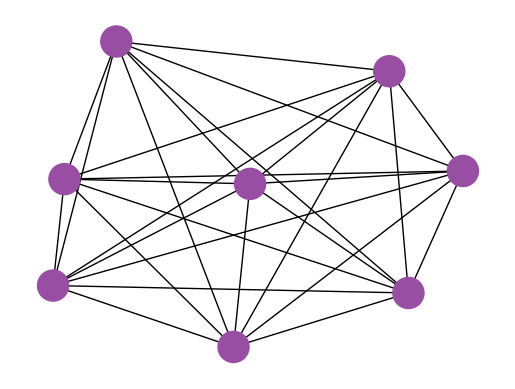

In [9]:
TopologyGenerator.plot_graph(fleet.graph, node_color_attr='dataset',
                            edge_color='black')

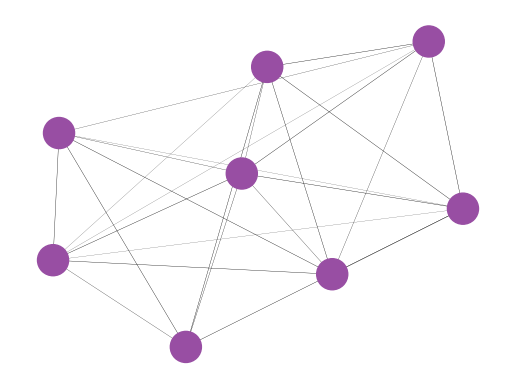

In [10]:
TopologyGenerator.plot_graph(fleet.graph, node_color_attr='dataset',
                            edge_color='black',
                            edge_widths=edge_widths)

In [11]:
seeds = range(8)
in_clus_ls, out_clus_ls = [], []
for seed in seeds:
    save_dir = get_save_dir(experiment_folder, experiment_name,
                            dataset, algo, num_trains_per_class, use_contrastive, seed)


    fleet = setup_fleet(save_dir, parallel=False, modify_cfg=modify_cfg)
    fleet.load_records()
    fleet.change_save_dir('combined_dataset_engineering_experiment_results')
    set_color(fleet)
    communication = get_communication(fleet,multiplier=1)
    in_clus, out_clus = compute_cluster_communications(fleet, communication)
    in_clus_ls.append(in_clus)
    out_clus_ls.append(out_clus)

{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'cifar100', 'num_tasks': 20, 'num_classes_per_task': 5, 'with_replacement': False, 'num_trains_per_class': 256, 'num_vals_per_class': -1, 'remap_labels': True}, 'net': {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5, 'no_sparse_basis': True}, 'sharing_strategy': {'name': 'modmod', 'num_coms_per_round': 2, 'module_selection': 'gt_most_similar', 'pre_or_post_comm': 'pre', 'opt_with_random': False, 'comm_freq': 100, 'sync_base': True, 'freeze_candidate_module': False, 'transfer_decoder': True, 'transfer_structure': True}, 'seed': 0, 'algo': 'modular', 'job_name': 'cifar100_modular_numtrain_256', 'num_agents': 8, 'root_save_dir': 'experiment_results/jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True

INFO:root:Class sequence: [97 66 33 19 34  3 12  2 13 92 80  5 27 60 36 11  9 25 31 87 58 44 94 95
 64 61 62 86 79 98 93 51 22 59 26 37 83 73 78  1 30 55 85 47 41 20 63 43
 90 88 21 40 15 75  4  0 52 23 35 53 84 69 16 10 71 81  6 91 56 76 38 50
 57 74 49 18 24 39 48 99  8 65 89 67 54 32 42 14 68 45 96 77 46 28 72 17
 29 82  7 70]
INFO:root:task 0 :(1280, 3, 32, 32) (469, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32, 32) (527, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 2 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 3 :(1280, 3, 32, 32) (532, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 4 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 5 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 6 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 7 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 8 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 9 :(1280, 3, 32, 32) (4

labels: [97 66 33 19 34  3 12  2 13 92 80  5 27 60 36 11  9 25 31 87 58 44 94 95
 64 61 62 86 79 98 93 51 22 59 26 37 83 73 78  1 30 55 85 47 41 20 63 43
 90 88 21 40 15 75  4  0 52 23 35 53 84 69 16 10 71 81  6 91 56 76 38 50
 57 74 49 18 24 39 48 99  8 65 89 67 54 32 42 14 68 45 96 77 46 28 72 17
 29 82  7 70]


INFO:root:task 13 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (504, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (475, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (471, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (532, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [13 55 29 67 64 47 58 19 30 38 15 16 34 35 73 96 25 89 63  5 44 21 28 60
 80 86 36 95 83 40  2 24 37 61 62 57 53 79 27 82 65  4 22 45 78 33 32  9
 90 56 46 48  7 59 41 93 98 69 51 74 68 72 71 39 54 18 91 76 70 11 10 99
 77 52 87 31  6  1 84 43 85 42 12 94 26 88 17 49 75 92  8 97 66 50  0 23
 20 81 14  3]
INFO:root:task 0 :(1280, 3, 32, 32) (478, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32, 32) (514, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 2 :(1280, 3, 32,

labels: [13 55 29 67 64 47 58 19 30 38 15 16 34 35 73 96 25 89 63  5 44 21 28 60
 80 86 36 95 83 40  2 24 37 61 62 57 53 79 27 82 65  4 22 45 78 33 32  9
 90 56 46 48  7 59 41 93 98 69 51 74 68 72 71 39 54 18 91 76 70 11 10 99
 77 52 87 31  6  1 84 43 85 42 12 94 26 88 17 49 75 92  8 97 66 50  0 23
 20 81 14  3]


INFO:root:task 12 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (474, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (474, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (474, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (485, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (537, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [11 37 44 67 45 66 96  1 88  4  2 84 22 50 29 28 41 82 25  5  9 77 13 17
 48 76 93 81 73 91 14 94 24 32 75 19 71 10 55 63 58 33 83 18 21  6 26 52
 68  3 78 57 80 15 59 99 86 95 92 30  0  8 53 49 35 31 16 61 60 47 98 40
 46 34 97 56 12 74 51 43 27 70 20 90 64 36 72 65 62 42 69  7 89 38 39 79
 85 23 87 54]
INFO:root:task 0 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32

labels: [11 37 44 67 45 66 96  1 88  4  2 84 22 50 29 28 41 82 25  5  9 77 13 17
 48 76 93 81 73 91 14 94 24 32 75 19 71 10 55 63 58 33 83 18 21  6 26 52
 68  3 78 57 80 15 59 99 86 95 92 30  0  8 53 49 35 31 16 61 60 47 98 40
 46 34 97 56 12 74 51 43 27 70 20 90 64 36 72 65 62 42 69  7 89 38 39 79
 85 23 87 54]


INFO:root:task 10 :(1280, 3, 32, 32) (514, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (460, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (529, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [63  2 24 65 38 56 94 61 75 55 25 96 86 32 11 64 30 67 80 27 41 52 20  0
 97 50 40 43 36 17 33 34 53 29 44 16 84 15 90 62 18 51 79 88 95 49 35 76
 59 31  8 14 68  9 71  6 73  5 66 28 72  1 13 93 60 12 78 26 98  4 46 39
  3 48 37 69 70 87 83 91 42 47 45 81 92 19 74

labels: [63  2 24 65 38 56 94 61 75 55 25 96 86 32 11 64 30 67 80 27 41 52 20  0
 97 50 40 43 36 17 33 34 53 29 44 16 84 15 90 62 18 51 79 88 95 49 35 76
 59 31  8 14 68  9 71  6 73  5 66 28 72  1 13 93 60 12 78 26 98  4 46 39
  3 48 37 69 70 87 83 91 42 47 45 81 92 19 74 89 22 10 82 23 77 85 99 58
 21 54  7 57]


INFO:root:task 10 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (490, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (504, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (555, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (471, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (455, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [ 6 30 52 18 83 48  1 71 97 53  5 31 72 49 11 40 59 27 14 75 63 41 93 74
 44  7 77 87 33 51 28 43 24 69 54 42 19 17 68  8  3 73 46 22  4 92 76 89
 78 56 61 91 50 67 45  0 36 99 79 64 96 21 29 32 98 70 88 57 39 47 12 81
 10  2 25 37 60 20 16 86  9 62 55 58 94 23 13

labels: [ 6 30 52 18 83 48  1 71 97 53  5 31 72 49 11 40 59 27 14 75 63 41 93 74
 44  7 77 87 33 51 28 43 24 69 54 42 19 17 68  8  3 73 46 22  4 92 76 89
 78 56 61 91 50 67 45  0 36 99 79 64 96 21 29 32 98 70 88 57 39 47 12 81
 10  2 25 37 60 20 16 86  9 62 55 58 94 23 13 35 90 80 34 84 15 95 82 85
 65 26 38 66]


INFO:root:task 10 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (512, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (513, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (505, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (474, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (525, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (493, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (479, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [31  6 72  5 12 20 71 70 26 66 52 42  2 47 56 86 21 33 76 16 80 98 97 79
 10 84 55  8 23 83 77 68 93 25 27 90 24 43 91 40 96 28  7 49 35 15 48 50
 18 53  0 92 58 34 95 32  9 64 11 60 73 14 39 19 51 88 99 29 13 87 41 69
 37  4  3 63 67 65 59 62 54 36 61 94 89 75 74

labels: [31  6 72  5 12 20 71 70 26 66 52 42  2 47 56 86 21 33 76 16 80 98 97 79
 10 84 55  8 23 83 77 68 93 25 27 90 24 43 91 40 96 28  7 49 35 15 48 50
 18 53  0 92 58 34 95 32  9 64 11 60 73 14 39 19 51 88 99 29 13 87 41 69
 37  4  3 63 67 65 59 62 54 36 61 94 89 75 74 30 78 46 85 22 17 81 57 44
 45 82 38  1]


INFO:root:task 10 :(1280, 3, 32, 32) (508, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (487, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (504, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (521, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (446, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (497, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (522, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [ 6 82 28 87 50 48  2  1 85 73 62 18 67 45 79 71 44 70  7 35 33 22  3 84
 14 58 24 91 83 72 59 90 41 51 43 25 29 92 63 56 46 47 26  0 39 17 34 97
 30 53 36 64 81 93 57 20 55 60 31 12 11 54  4 94 49 68 78 38 98 10 19 66
 96 37  9 69 76 13 89  8 74 23 15  5 52 61 95

labels: [ 6 82 28 87 50 48  2  1 85 73 62 18 67 45 79 71 44 70  7 35 33 22  3 84
 14 58 24 91 83 72 59 90 41 51 43 25 29 92 63 56 46 47 26  0 39 17 34 97
 30 53 36 64 81 93 57 20 55 60 31 12 11 54  4 94 49 68 78 38 98 10 19 66
 96 37  9 69 76 13 89  8 74 23 15  5 52 61 95 65 32 21 42 40 27 16 99 77
 75 88 80 86]


INFO:root:task 10 :(1280, 3, 32, 32) (480, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (524, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (517, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (484, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (471, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (472, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [66 65 15 81 88 34 41  4 33 29 76 82 38 94 85 57 86 11 95 78 77 67 53 75
 27 99 91 21 32  6 60 96 44 46 70 68 74 63 72 35 56  2 62 31 13  1 42  9
 80 58 83 25 97 17 73 16 37 71 54 52 93 48 19 47 98  7 45 14 23 18 40 64
 69  5 87 59 61 22 43 10 26 90 89  8 79 55 49

labels: [66 65 15 81 88 34 41  4 33 29 76 82 38 94 85 57 86 11 95 78 77 67 53 75
 27 99 91 21 32  6 60 96 44 46 70 68 74 63 72 35 56  2 62 31 13  1 42  9
 80 58 83 25 97 17 73 16 37 71 54 52 93 48 19 47 98  7 45 14 23 18 40 64
 69  5 87 59 61 22 43 10 26 90 89  8 79 55 49 24 20 92 50  3  0 51 30 36
 28 39 84 12]


INFO:root:task 10 :(1280, 3, 32, 32) (505, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (487, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (520, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (482, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)


i_size 32
num_classes 5
net_cfg {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5, 'no_sparse_basis': True, 'i_size': 32, 'num_classes': 5, 'num_tasks': 20, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:Class sequence: [ 7  8 19 18 48 59 36 34 75 30 93 86 53  6  9 77 95 89 39 55 71 32 61 12
 50 99 74 96 24 69 49 57 47 78  1 62 73  0 37 40 70 65 27  5 83 98 91 51
 15 72 64 60 20 23 82 45 44 63 68 17 25 11 76 16  3 58 67  2 90 21 35 94
 14 28 56 22 85 81 26 79 66 54 92 52 43 97 87 10 80  4 33 46 29 88 84 41
 31 38 13 42]
INFO:root:task 0 :(1280, 3, 32, 32) (473, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 2 :(1280, 3, 32, 32) (533, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 3 :(1280, 3, 32, 32) (493, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 4 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 5 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 6 :(1280, 3, 32, 32) (511, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 7 :(1280, 3, 32, 32) (512, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 8 :(1280, 3, 32, 32) (481, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 9 :(1280, 3, 32, 32) (5

labels: [ 7  8 19 18 48 59 36 34 75 30 93 86 53  6  9 77 95 89 39 55 71 32 61 12
 50 99 74 96 24 69 49 57 47 78  1 62 73  0 37 40 70 65 27  5 83 98 91 51
 15 72 64 60 20 23 82 45 44 63 68 17 25 11 76 16  3 58 67  2 90 21 35 94
 14 28 56 22 85 81 26 79 66 54 92 52 43 97 87 10 80  4 33 46 29 88 84 41
 31 38 13 42]


INFO:root:task 10 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (505, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (470, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (537, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (477, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (498, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (482, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Agent: node_id: 69420, seed: 69420000
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:TRYOUT SELECTION
INFO:root:Agent: 

Setting seed 69420000
Setting seed 0
Setting seed 1000
Setting seed 2000
Setting seed 3000
Setting seed 4000
Setting seed 5000
Setting seed 6000
Setting seed 7000
{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'cifar100', 'num_tasks': 20, 'num_classes_per_task': 5, 'with_replacement': False, 'num_trains_per_class': 256, 'num_vals_per_class': -1, 'remap_labels': True}, 'net': {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5, 'no_sparse_basis': True}, 'sharing_strategy': {'name': 'modmod', 'num_coms_per_round': 2, 'module_selection': 'gt_most_similar', 'pre_or_post_comm': 'pre', 'opt_with_random': False, 'comm_freq': 100, 'sync_base': True, 'freeze_candidate_module': False, 'transfer_decoder': True, 'transfer_structure': True}, 'seed': 1, 'algo': 'modular', 'job_name': 'cifar100_modular_numtrain_256', 'num_age

INFO:root:Class sequence: [68 60 90 97 15 26 40 87 73  0  2 21 92 76 64 35 83 28 46 45 71 70 55  3
  8 47 74 94 86 31 11 34 32 96 69 22 82 95 18 52 13 33 16 84 53 75 57 36
 30 12  5 93  9 51 72 56 78 65 88 24 44  4 27 37 48 62 14 50 43 42 29 63
 81 91 67 23 39 85 10 41 25 59 38 80 54 17 20  6 79 98  7 61 19 58 89 66
 49  1 99 77]
INFO:root:task 0 :(1280, 3, 32, 32) (446, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32, 32) (482, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 2 :(1280, 3, 32, 32) (518, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 3 :(1280, 3, 32, 32) (531, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 4 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 5 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 6 :(1280, 3, 32, 32) (498, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 7 :(1280, 3, 32, 32) (512, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 8 :(1280, 3, 32, 32) (490, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 9 :(1280, 3, 32, 32) (4

labels: [68 60 90 97 15 26 40 87 73  0  2 21 92 76 64 35 83 28 46 45 71 70 55  3
  8 47 74 94 86 31 11 34 32 96 69 22 82 95 18 52 13 33 16 84 53 75 57 36
 30 12  5 93  9 51 72 56 78 65 88 24 44  4 27 37 48 62 14 50 43 42 29 63
 81 91 67 23 39 85 10 41 25 59 38 80 54 17 20  6 79 98  7 61 19 58 89 66
 49  1 99 77]


INFO:root:task 11 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (543, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (461, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (487, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (520, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [63 93 97 51 96 92 82  6 32 20 70 54 17 84 77 62 86 75  1 31 45 27 25 33
 76 11 56 13 36 87 37 24 28 65 44 48 81 42 12 74 40 16 55 72 88 90 43 66
 47  9 99 19 67  8 50 38 39 69 73 52 18 60 22  3 15 57 68 91 71 85  4 61
 94 26 23 83 10 30 46 53 29 79  5 58  7 21 59 98 64 14 80 89 35 95 78  2
  0 41 49 34]
INFO:root:task 0 :(1280, 3, 3

labels: [63 93 97 51 96 92 82  6 32 20 70 54 17 84 77 62 86 75  1 31 45 27 25 33
 76 11 56 13 36 87 37 24 28 65 44 48 81 42 12 74 40 16 55 72 88 90 43 66
 47  9 99 19 67  8 50 38 39 69 73 52 18 60 22  3 15 57 68 91 71 85  4 61
 94 26 23 83 10 30 46 53 29 79  5 58  7 21 59 98 64 14 80 89 35 95 78  2
  0 41 49 34]


INFO:root:task 10 :(1280, 3, 32, 32) (515, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (487, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (508, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (480, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (486, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (532, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [13  0 10 22  2 93 80  5  7 99 94 76 54 12 83  9 39  8 87 98 32 46 61 69
 70 92 71 29 27 75 21 17 85  1 74 97 43 91 51 59 14 20 63  6 41 25 81 65
 53 57 67 35 31 45 64 44 68 30 84 73 86 26 95 37 48 56 15 78 38 19 90 58
 34 77 89 88 36 42 23 52 33  3 62 55 40 60 50

labels: [13  0 10 22  2 93 80  5  7 99 94 76 54 12 83  9 39  8 87 98 32 46 61 69
 70 92 71 29 27 75 21 17 85  1 74 97 43 91 51 59 14 20 63  6 41 25 81 65
 53 57 67 35 31 45 64 44 68 30 84 73 86 26 95 37 48 56 15 78 38 19 90 58
 34 77 89 88 36 42 23 52 33  3 62 55 40 60 50 72 24 16 82 28 18 49 47 66
 96 79 11  4]


INFO:root:task 10 :(1280, 3, 32, 32) (497, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (484, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (523, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (508, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [ 5 81 60 19 41 97 98 51 26 84 80 17 82  2 44 83 75  8 45 93  9  0 94 52
 10 99 16 24 11 27 34 65 30 12 92 56 42 55 87 88  7 33 32 91 29 40 20 86
 96 48 31 71 79 72 46 61 36  4 18 43  1 28 53 54 25 78 90 74 37 38 95 69
 14 58 23 62 64 76 68 13 22 63 47  6 21 35  3

labels: [ 5 81 60 19 41 97 98 51 26 84 80 17 82  2 44 83 75  8 45 93  9  0 94 52
 10 99 16 24 11 27 34 65 30 12 92 56 42 55 87 88  7 33 32 91 29 40 20 86
 96 48 31 71 79 72 46 61 36  4 18 43  1 28 53 54 25 78 90 74 37 38 95 69
 14 58 23 62 64 76 68 13 22 63 47  6 21 35  3 89 77 39 67 70 66 15 73 85
 50 59 57 49]


INFO:root:task 11 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (498, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (482, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (519, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (459, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [49 43 99 84 92 28 29 19 40 13 58  7 72 11 15 33 35 78 16 62 26 18  5 47
 83 54 12 45 38 24 67 77 95  8 50 57 41 79 36 31 85 81 14 21 34 90 76 32
 61 66 56 69 25 89 23 48  4  6 37 75 65 59 39 86 93 53 17 55 97 60 64  1
 98 80 10 44 52 51 27 87 46 68 91  3 73 30  0 74 82  2 96 88  9 70 63 22
 94 42 20 71]
INFO:root:task 0 :(1280, 3, 3

labels: [49 43 99 84 92 28 29 19 40 13 58  7 72 11 15 33 35 78 16 62 26 18  5 47
 83 54 12 45 38 24 67 77 95  8 50 57 41 79 36 31 85 81 14 21 34 90 76 32
 61 66 56 69 25 89 23 48  4  6 37 75 65 59 39 86 93 53 17 55 97 60 64  1
 98 80 10 44 52 51 27 87 46 68 91  3 73 30  0 74 82  2 96 88  9 70 63 22
 94 42 20 71]


INFO:root:task 11 :(1280, 3, 32, 32) (519, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (484, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (485, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (513, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (525, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (493, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (449, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (517, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (512, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [ 6 29 16 26 78 10 11 53 87 36 33 52 12 19 69 35 27 71 90 23 13 32  1 57
 73 63 83 28 61 39 95 31 34 79 30 21 44 43 86  8 77 67 49 89 24 72  4 15
 94 74 62 37 88 40 59 85  2 92 93 96 98  7 60 55 41 54 22 68  5 64 14  3
 25 42 50 56 82 47 84 17  9 99  0 81 97 58 20 66 48 18 76 45 80 70 51 65
 38 91 75 46]
INFO:root:task 0 :(1280, 3, 3

labels: [ 6 29 16 26 78 10 11 53 87 36 33 52 12 19 69 35 27 71 90 23 13 32  1 57
 73 63 83 28 61 39 95 31 34 79 30 21 44 43 86  8 77 67 49 89 24 72  4 15
 94 74 62 37 88 40 59 85  2 92 93 96 98  7 60 55 41 54 22 68  5 64 14  3
 25 42 50 56 82 47 84 17  9 99  0 81 97 58 20 66 48 18 76 45 80 70 51 65
 38 91 75 46]


INFO:root:task 11 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (519, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (504, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [19 71 11 32  9 85 67 24  1 17 58 34 82 15 77 74 10 43 23 64 93 26 92 79
 39 56 97 25 70 52 54 45 36 28 27  4 60  5 16 63 42 30 38 84 55 94 72  3
 35 69 48 80 46 73 81 22 14 33 91 90 83 40  2 68 49 75 53  8 44 47 86 62
 65 13 12 95 88 37 57 98 59 18  6 78 50 61 66  0 29 76  7 20 87 89 41 21
 31 99 51 96]
INFO:root:task 0 :(1280, 3, 3

labels: [19 71 11 32  9 85 67 24  1 17 58 34 82 15 77 74 10 43 23 64 93 26 92 79
 39 56 97 25 70 52 54 45 36 28 27  4 60  5 16 63 42 30 38 84 55 94 72  3
 35 69 48 80 46 73 81 22 14 33 91 90 83 40  2 68 49 75 53  8 44 47 86 62
 65 13 12 95 88 37 57 98 59 18  6 78 50 61 66  0 29 76  7 20 87 89 41 21
 31 99 51 96]


INFO:root:task 11 :(1280, 3, 32, 32) (467, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (512, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (497, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (487, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (468, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (498, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (550, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [61 99 26 84 59 52 12 76 78 34 39 89 25 64  9 60 24  7  4 73 75 98 86 41
 57 90 37 92  2 20 21 15 94 40 38 96 47 11 87 80 51 55 19 33  3 35 44 74
 10 50 83 97 82 30  1 29 63 18 53 91  5 17 45 56 32 79 70 69 13 22 48 88
  8 95 54 62 36  0 28 58 71 43 23 77 27 93 49 85 31 67 14 16 66 68 42  6
 65 46 81 72]
INFO:root:task 0 :(1280, 3, 3

labels: [61 99 26 84 59 52 12 76 78 34 39 89 25 64  9 60 24  7  4 73 75 98 86 41
 57 90 37 92  2 20 21 15 94 40 38 96 47 11 87 80 51 55 19 33  3 35 44 74
 10 50 83 97 82 30  1 29 63 18 53 91  5 17 45 56 32 79 70 69 13 22 48 88
  8 95 54 62 36  0 28 58 71 43 23 77 27 93 49 85 31 67 14 16 66 68 42  6
 65 46 81 72]


INFO:root:task 11 :(1280, 3, 32, 32) (514, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (527, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (489, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (498, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (513, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (466, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (515, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (512, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (538, 3, 32, 32) (500, 3, 32, 32)


i_size 32
num_classes 5
net_cfg {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5, 'no_sparse_basis': True, 'i_size': 32, 'num_classes': 5, 'num_tasks': 20, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:Class sequence: [16 70 14 17 77 57 30 29  3 34 27 79 32 33 83 72 63 65 76 73 52 95 61 26
 44 20 98 13  5 81 38  7 42 99 23 45  4 75 59  9 58 80 84 64 24 92 25 48
 60 15 37 90 88 86 50 49  2 54 71 56 22 18 53  0 10 47  6 12  8 93 51 89
 35 41 94 36 91 28 43 66 39  1 62 82 55 97 87 78 19 40 74 21 31 85 68 69
 11 46 96 67]
INFO:root:task 0 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 2 :(1280, 3, 32, 32) (508, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 3 :(1280, 3, 32, 32) (476, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 4 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 5 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 6 :(1280, 3, 32, 32) (497, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 7 :(1280, 3, 32, 32) (497, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 8 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 9 :(1280, 3, 32, 32) (5

labels: [16 70 14 17 77 57 30 29  3 34 27 79 32 33 83 72 63 65 76 73 52 95 61 26
 44 20 98 13  5 81 38  7 42 99 23 45  4 75 59  9 58 80 84 64 24 92 25 48
 60 15 37 90 88 86 50 49  2 54 71 56 22 18 53  0 10 47  6 12  8 93 51 89
 35 41 94 36 91 28 43 66 39  1 62 82 55 97 87 78 19 40 74 21 31 85 68 69
 11 46 96 67]


INFO:root:task 11 :(1280, 3, 32, 32) (521, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (477, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (540, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (514, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (481, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (477, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (480, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (474, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (522, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Agent: node_id: 69420, seed: 69420001
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 0, seed: 1
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 1, seed: 1001
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 2, seed: 2001
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 3, seed: 3001
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node

Setting seed 69420001
Setting seed 1
Setting seed 1001
Setting seed 2001
Setting seed 3001
Setting seed 4001
Setting seed 5001
Setting seed 6001
Setting seed 7001
{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'cifar100', 'num_tasks': 20, 'num_classes_per_task': 5, 'with_replacement': False, 'num_trains_per_class': 256, 'num_vals_per_class': -1, 'remap_labels': True}, 'net': {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5, 'no_sparse_basis': True}, 'sharing_strategy': {'name': 'modmod', 'num_coms_per_round': 2, 'module_selection': 'gt_most_similar', 'pre_or_post_comm': 'pre', 'opt_with_random': False, 'comm_freq': 100, 'sync_base': True, 'freeze_candidate_module': False, 'transfer_decoder': True, 'transfer_structure': True}, 'seed': 2, 'algo': 'modular', 'job_name': 'cifar100_modular_numtrain_256', 'num_age

INFO:root:Class sequence: [72 45 38 48 97 37  0 73 36 20 51 58 61 21 95 64 25 43 53 23 39 91 24 57
  9 15 33 11 88 62 59 77 18 12 19 32  6  5 87 63 60  1 42 81  2 79 41 31
  4  7 30 68 22 76 16 65 28 69 47 71 49 54 29 55 80 14 34 74 94 85 98 84
 89 44  3 75 96 46 10 13 50 56 40 83 17 67 99 35 86  8 52 90 70 66 27 82
 26 93 92 78]
INFO:root:task 0 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32, 32) (489, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 2 :(1280, 3, 32, 32) (482, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 3 :(1280, 3, 32, 32) (465, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 4 :(1280, 3, 32, 32) (514, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 5 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 6 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 7 :(1280, 3, 32, 32) (519, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 8 :(1280, 3, 32, 32) (481, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 9 :(1280, 3, 32, 32) (5

labels: [72 45 38 48 97 37  0 73 36 20 51 58 61 21 95 64 25 43 53 23 39 91 24 57
  9 15 33 11 88 62 59 77 18 12 19 32  6  5 87 63 60  1 42 81  2 79 41 31
  4  7 30 68 22 76 16 65 28 69 47 71 49 54 29 55 80 14 34 74 94 85 98 84
 89 44  3 75 96 46 10 13 50 56 40 83 17 67 99 35 86  8 52 90 70 66 27 82
 26 93 92 78]


INFO:root:task 11 :(1280, 3, 32, 32) (537, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (513, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (485, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (484, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (532, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (489, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [90  0 72 54 87 26 45 56 98 63  7  9 95 36 52 73 30  3  6 16 49 24 34 35
 59 46 51 71 23 74 21 86 70 25 37 40 10 22 44 18 19 29 32 93 77 11 69 66
 88  2 76 99 17 75 68 14 47 97  5 31 80 60 57 65 67 38 81 85  8 39 79 64
 62 61 89  4 13 12 84 42 15 48 20 27 41 43 28 96 50 91 53 94 33 55 82 83
  1 58 78 92]
INFO:root:task 0 :(1280, 3, 3

labels: [90  0 72 54 87 26 45 56 98 63  7  9 95 36 52 73 30  3  6 16 49 24 34 35
 59 46 51 71 23 74 21 86 70 25 37 40 10 22 44 18 19 29 32 93 77 11 69 66
 88  2 76 99 17 75 68 14 47 97  5 31 80 60 57 65 67 38 81 85  8 39 79 64
 62 61 89  4 13 12 84 42 15 48 20 27 41 43 28 96 50 91 53 94 33 55 82 83
  1 58 78 92]


INFO:root:task 10 :(1280, 3, 32, 32) (473, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (461, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (531, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (522, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (523, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (472, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (513, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (484, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [32 45 93 34 69 92 84 55  5 18 61 89 74 81 87 41 52 53 22 75 10 36 96 16
 15 58  2 40 83  4 60  1 73 91 39 90 54 66 71 42 99 14 67 23 79 37 85 38
 33 29 63 35  0  8 68 17 62 31 76  6 24 65 27 77 28 72 78 30  7 94 48 59
  9 82  3 86 12 50 97 70 26 47 51 20 44 88 25

labels: [32 45 93 34 69 92 84 55  5 18 61 89 74 81 87 41 52 53 22 75 10 36 96 16
 15 58  2 40 83  4 60  1 73 91 39 90 54 66 71 42 99 14 67 23 79 37 85 38
 33 29 63 35  0  8 68 17 62 31 76  6 24 65 27 77 28 72 78 30  7 94 48 59
  9 82  3 86 12 50 97 70 26 47 51 20 44 88 25 95 49 21 80 98 56 64 43 13
 57 19 11 46]


INFO:root:task 10 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (485, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (545, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (480, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (458, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (518, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (524, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [79 12 44 60 49 68 84 33 18 39 16 36 10 83 69 65 63 85 71 93 37 76 55 59
  2 21 42 81 41 74 98 31  1 52 91 64 43 51  5 22 34 15 61 94 54 50 89 72
 13 75 67  6 88 11  8 87 58 53 82 92 80 90 78 26  9 40 97 73 48  7 77 35
 23 57 14 32 46 24 19 38 27 96 20 47  3 25  4

labels: [79 12 44 60 49 68 84 33 18 39 16 36 10 83 69 65 63 85 71 93 37 76 55 59
  2 21 42 81 41 74 98 31  1 52 91 64 43 51  5 22 34 15 61 94 54 50 89 72
 13 75 67  6 88 11  8 87 58 53 82 92 80 90 78 26  9 40 97 73 48  7 77 35
 23 57 14 32 46 24 19 38 27 96 20 47  3 25  4 56 29 62  0 45 99 28 66 17
 86 95 70 30]


INFO:root:task 10 :(1280, 3, 32, 32) (508, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (529, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (526, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (469, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (479, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (468, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (521, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [38 48 52 84 26 14 96  8 83 12 33 63 89 87 78 66 28  0  1 22 95 30  6 71
 42 13 79 62 10 80 50  2 47 73 40 41 43 18 19 68 67 91  4 23 32 55 57 64
 82 54 74 53 39 31 97 88 58 46 16 27 37 20 59  9 92  7 99 90 11 93 34 17
 77  5 65 45 44 60 29 49 86 35 21 81 56 51 85

labels: [38 48 52 84 26 14 96  8 83 12 33 63 89 87 78 66 28  0  1 22 95 30  6 71
 42 13 79 62 10 80 50  2 47 73 40 41 43 18 19 68 67 91  4 23 32 55 57 64
 82 54 74 53 39 31 97 88 58 46 16 27 37 20 59  9 92  7 99 90 11 93 34 17
 77  5 65 45 44 60 29 49 86 35 21 81 56 51 85  3 76 75 69 72 61 15 24 25
 94 98 36 70]


INFO:root:task 11 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (461, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (466, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (517, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [68 10 70 13 93 42 26 61 16 80  1 38 67 86 90 54 28 25 31 97 46 19 65 15
 75 55 71 92 98 27 52 72 51 33 73 47 34 35 43 32 84 77 37  3 49 11  7 17
 85 23 21 40 57 44 62 94 20 66 58  9 59 48 29 81 45 83  4 91 76 18 79  0
 82 14 41 24 88 89 60 99 69 53  6 12 22 64 74 30 96 63 50 39 95 87  8 56
 78 36  5  2]
INFO:root:task 0 :(1280, 3, 3

labels: [68 10 70 13 93 42 26 61 16 80  1 38 67 86 90 54 28 25 31 97 46 19 65 15
 75 55 71 92 98 27 52 72 51 33 73 47 34 35 43 32 84 77 37  3 49 11  7 17
 85 23 21 40 57 44 62 94 20 66 58  9 59 48 29 81 45 83  4 91 76 18 79  0
 82 14 41 24 88 89 60 99 69 53  6 12 22 64 74 30 96 63 50 39 95 87  8 56
 78 36  5  2]


INFO:root:task 10 :(1280, 3, 32, 32) (478, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (518, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (512, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (517, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (480, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (467, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (484, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [92 61 95 22 25 20  3 13 71 48 59 42 85  6 12 90 65 49  5 41 52 64 83 43
 77  2 70 81 40 19 55 53 37 86 50 29 24 21 47 96 38  0 67 94 18 54 79 14
 51 73 62  9 45 76 10 82 91 34  4 63 74 97 28 56 98 35 72 30 84 46 93 75
 33 36  7  1 17 15 99 39 60 78 31 87 11 69 68

labels: [92 61 95 22 25 20  3 13 71 48 59 42 85  6 12 90 65 49  5 41 52 64 83 43
 77  2 70 81 40 19 55 53 37 86 50 29 24 21 47 96 38  0 67 94 18 54 79 14
 51 73 62  9 45 76 10 82 91 34  4 63 74 97 28 56 98 35 72 30 84 46 93 75
 33 36  7  1 17 15 99 39 60 78 31 87 11 69 68 44 26 16 66 27 80 57 58 32
 23  8 89 88]


INFO:root:task 10 :(1280, 3, 32, 32) (498, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (459, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (498, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (468, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (536, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [90 52 66  6  8 35 63 30 29 25 91  1 39 76 14 67 12 85 80 48  9 11 61 69
 75 64 74 83 96 50 99 59 54 45 23 47 72 10 15 56 46 36 62 93 89 79 81 32
 77 88 60 37  2 73 21 71 18 97 40 68 86 42 87 95 38 55 19 57 98 49  3 27
 26 34  4 53  7 70 24 13 20 16 33  5 82 41 17

labels: [90 52 66  6  8 35 63 30 29 25 91  1 39 76 14 67 12 85 80 48  9 11 61 69
 75 64 74 83 96 50 99 59 54 45 23 47 72 10 15 56 46 36 62 93 89 79 81 32
 77 88 60 37  2 73 21 71 18 97 40 68 86 42 87 95 38 55 19 57 98 49  3 27
 26 34  4 53  7 70 24 13 20 16 33  5 82 41 17 43 84 31 65 94 51 28 44  0
 78 58 92 22]


INFO:root:task 10 :(1280, 3, 32, 32) (490, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (515, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (450, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (480, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (487, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (521, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (513, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)


i_size 32
num_classes 5
net_cfg {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5, 'no_sparse_basis': True, 'i_size': 32, 'num_classes': 5, 'num_tasks': 20, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:Class sequence: [77 14 15 61 40 29  6  8 86 73 47 17 35 42 65 51 26 49 87  2 78  0 71 89
  9 85 57 20 96 79 84 46 91 28 68 88 45  1 60 31 72 75 21 25 97 56 18 99
 66 53 43 44 82 52  4 74 63 38 39 58 54  3 76 10 19 70 41 11 24 16 64  7
 34 23 81 27 98 94 32 33 59 13 69 83 12 62 90 93 30 95 22 67 36 80  5 50
 92 55 37 48]
INFO:root:task 0 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32, 32) (521, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 2 :(1280, 3, 32, 32) (477, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 3 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 4 :(1280, 3, 32, 32) (548, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 5 :(1280, 3, 32, 32) (519, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 6 :(1280, 3, 32, 32) (493, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 7 :(1280, 3, 32, 32) (480, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 8 :(1280, 3, 32, 32) (508, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 9 :(1280, 3, 32, 32) (4

labels: [77 14 15 61 40 29  6  8 86 73 47 17 35 42 65 51 26 49 87  2 78  0 71 89
  9 85 57 20 96 79 84 46 91 28 68 88 45  1 60 31 72 75 21 25 97 56 18 99
 66 53 43 44 82 52  4 74 63 38 39 58 54  3 76 10 19 70 41 11 24 16 64  7
 34 23 81 27 98 94 32 33 59 13 69 83 12 62 90 93 30 95 22 67 36 80  5 50
 92 55 37 48]


INFO:root:task 10 :(1280, 3, 32, 32) (487, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (551, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (470, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (480, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (515, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (478, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Agent: node_id: 69420, seed: 69420002
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 0, seed: 2
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 1, seed: 1002
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 2, seed: 2002
INFO:root:TRYOUT SELECTION
INFO:root:Agent: 

Setting seed 69420002
Setting seed 2
Setting seed 1002
Setting seed 2002
Setting seed 3002
Setting seed 4002
Setting seed 5002
Setting seed 6002
Setting seed 7002
{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'cifar100', 'num_tasks': 20, 'num_classes_per_task': 5, 'with_replacement': False, 'num_trains_per_class': 256, 'num_vals_per_class': -1, 'remap_labels': True}, 'net': {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5, 'no_sparse_basis': True}, 'sharing_strategy': {'name': 'modmod', 'num_coms_per_round': 2, 'module_selection': 'gt_most_similar', 'pre_or_post_comm': 'pre', 'opt_with_random': False, 'comm_freq': 100, 'sync_base': True, 'freeze_candidate_module': False, 'transfer_decoder': True, 'transfer_structure': True}, 'seed': 3, 'algo': 'modular', 'job_name': 'cifar100_modular_numtrain_256', 'num_age

INFO:root:Class sequence: [21 62 58  5 71 11 42 15 53 36 30 99 75 48 82 93 40 38  1 91 41  3 16 64
 61 14 90 28 35 88 95 80  4 10  9 85 45 66  0 17 27 67 12 37 50 18 86 39
 54 68 22 43 46 69 31 19 52 76 59  6 25 73 72 32 24 60  2 96 84 98 97 56
 81 49 63 83 74 65 77 55 51 92 26 23 44 87  8 20 89 13 29 70 33 47 78 57
 79 94 34  7]
INFO:root:task 0 :(1280, 3, 32, 32) (460, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32, 32) (486, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 2 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 3 :(1280, 3, 32, 32) (515, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 4 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 5 :(1280, 3, 32, 32) (476, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 6 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 7 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 8 :(1280, 3, 32, 32) (487, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 9 :(1280, 3, 32, 32) (5

labels: [21 62 58  5 71 11 42 15 53 36 30 99 75 48 82 93 40 38  1 91 41  3 16 64
 61 14 90 28 35 88 95 80  4 10  9 85 45 66  0 17 27 67 12 37 50 18 86 39
 54 68 22 43 46 69 31 19 52 76 59  6 25 73 72 32 24 60  2 96 84 98 97 56
 81 49 63 83 74 65 77 55 51 92 26 23 44 87  8 20 89 13 29 70 33 47 78 57
 79 94 34  7]


INFO:root:task 10 :(1280, 3, 32, 32) (517, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (519, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (515, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (489, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (474, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (489, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (523, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (524, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [41 42 21 46 76 39 57 84 65 75  0 11  1 94 83  9  3 64 89 34 95 38 93 27
  8 92 22 52 91 61 23 48 30 80 60 79 13 69 37 72 33 51  7 68 25 12 58 36
 85 40  5 82 32  4 20 16 62 90 86 74 63 71  6  2 28 15 81 35 66 50 73 70
 97 45 53 78 49 99 26 77 55 88 43 98 10 87 67

labels: [41 42 21 46 76 39 57 84 65 75  0 11  1 94 83  9  3 64 89 34 95 38 93 27
  8 92 22 52 91 61 23 48 30 80 60 79 13 69 37 72 33 51  7 68 25 12 58 36
 85 40  5 82 32  4 20 16 62 90 86 74 63 71  6  2 28 15 81 35 66 50 73 70
 97 45 53 78 49 99 26 77 55 88 43 98 10 87 67 24 44 19 14 18 17 54 59 31
 47 56 96 29]


INFO:root:task 10 :(1280, 3, 32, 32) (553, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (520, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (479, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (484, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (471, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (511, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (514, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [86 40  6 87 33 69 16 50 66 54 20 62  2 93 64 46 65  5 39 58 77 15 85 18
 31 48 97  1 73 67 51 96 36 21 52 43 60 14  9 98 75 41 63 89 72 34 26 88
 84 38 13 10 22 32 92 76 99 29 70  3  4 24 56 55 83 19 68 47 57 25 30  0
 28 37 95 27 23 53 80 45 74 79 12 81 82 35 11

labels: [86 40  6 87 33 69 16 50 66 54 20 62  2 93 64 46 65  5 39 58 77 15 85 18
 31 48 97  1 73 67 51 96 36 21 52 43 60 14  9 98 75 41 63 89 72 34 26 88
 84 38 13 10 22 32 92 76 99 29 70  3  4 24 56 55 83 19 68 47 57 25 30  0
 28 37 95 27 23 53 80 45 74 79 12 81 82 35 11 78 49 71 61 90 94  7 44 42
 17 59  8 91]


INFO:root:task 10 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (480, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (480, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (508, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (470, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (520, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (511, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [85 51 44 99 16 21 52 42 43 35 91 23 89 46 59 33 58 94  5 86  8 10 39 74
 28  7  3 45  2  1 53 64 54 56 41 71 92 25 20  6 17 90 60 61 79 47 95 29
 37 80 96 27 66 24 34 87 81 63  4 83 49 31 68 76 30 69 55 84 73 13 50 14
 19 26 97 15  0 78 38 77 88 48 72 18 32 82 98

labels: [85 51 44 99 16 21 52 42 43 35 91 23 89 46 59 33 58 94  5 86  8 10 39 74
 28  7  3 45  2  1 53 64 54 56 41 71 92 25 20  6 17 90 60 61 79 47 95 29
 37 80 96 27 66 24 34 87 81 63  4 83 49 31 68 76 30 69 55 84 73 13 50 14
 19 26 97 15  0 78 38 77 88 48 72 18 32 82 98  9 57 11 70 40 75 67 62 22
 93 65 36 12]


INFO:root:task 10 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (505, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (512, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (529, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (481, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (525, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (479, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (487, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [29 69 65 71 94 91 92 55 44 32 28 35 22 47  2 79 63 74 57  7 39 25 31 19
 15 30 66 14  0 10  3 50 12 34 93 54 78 87 70 23 90 11  4 73 46 89 36  9
  1 84  5 27 20 95 52 86 85 42 17 77 64 33 48 38 43 41 49 18 40 83 76 98
 96 51 56 45 75 99 67 60 59 21 58  8 62 97 82

labels: [29 69 65 71 94 91 92 55 44 32 28 35 22 47  2 79 63 74 57  7 39 25 31 19
 15 30 66 14  0 10  3 50 12 34 93 54 78 87 70 23 90 11  4 73 46 89 36  9
  1 84  5 27 20 95 52 86 85 42 17 77 64 33 48 38 43 41 49 18 40 83 76 98
 96 51 56 45 75 99 67 60 59 21 58  8 62 97 82 24 26 80 88 13 72 16 81  6
 68 37 53 61]


INFO:root:task 10 :(1280, 3, 32, 32) (473, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (514, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (478, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (533, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (470, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (490, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [21 27 59 90 47 51 60 56 98 15 41 24 43 70 68 20 79 16 38 26 86 69 93 40
 58 82 97 87 28 83 71  7 35 64  4 85 81 77  8 54 74  5 29  0 66 53 12 49
 10 99 50  3 89 80 95 55 96  6 48 75 18 57 32 92 62 11 94  1 44 88 61 78
 14 37 13 46 63 30 45 67 52 22 65 25  2 33 34

labels: [21 27 59 90 47 51 60 56 98 15 41 24 43 70 68 20 79 16 38 26 86 69 93 40
 58 82 97 87 28 83 71  7 35 64  4 85 81 77  8 54 74  5 29  0 66 53 12 49
 10 99 50  3 89 80 95 55 96  6 48 75 18 57 32 92 62 11 94  1 44 88 61 78
 14 37 13 46 63 30 45 67 52 22 65 25  2 33 34 31 72 42  9 39 76 84 17 73
 19 91 36 23]


INFO:root:task 10 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (540, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (485, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (484, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (481, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (543, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (538, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [37 42 93 65 96 98 97 24 74  8 82 39 94 81 27 48 14 47 92 88 18 19 78 11
  6 30 85 70 95 28 22 54 56 67 90 12 66 38  4 31 13  2 16 52 45 43 63 34
 76 75 51 89 57 91 49 40 60 25 86 17  7 33 80 68 83 50 79 64 36 32 73 44
  9 55 77 35 23 72 15 59 26  5 46  3 41 61 87

labels: [37 42 93 65 96 98 97 24 74  8 82 39 94 81 27 48 14 47 92 88 18 19 78 11
  6 30 85 70 95 28 22 54 56 67 90 12 66 38  4 31 13  2 16 52 45 43 63 34
 76 75 51 89 57 91 49 40 60 25 86 17  7 33 80 68 83 50 79 64 36 32 73 44
  9 55 77 35 23 72 15 59 26  5 46  3 41 61 87 99 69  1 29 58 53 62  0 84
 21 10 71 20]


INFO:root:task 10 :(1280, 3, 32, 32) (484, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (539, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (489, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (487, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (527, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (475, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (519, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [11  0 95 49 88 87 16 63  9 70 92 45 64 46 12  6 56 94 28 68 43 47 85 48
 32 21 52 27 17 83 54 65 10 74 80 67  8  3 24 22 84 72 91 30 51 61 53 20
 79 41 29 34 93  1 57 59 31 36 66 18 19 77 96 37 15 38 82 39 71 69 89  7
 81 50 62 42 25 40 60 55  5 26  4 90 58 35 33

labels: [11  0 95 49 88 87 16 63  9 70 92 45 64 46 12  6 56 94 28 68 43 47 85 48
 32 21 52 27 17 83 54 65 10 74 80 67  8  3 24 22 84 72 91 30 51 61 53 20
 79 41 29 34 93  1 57 59 31 36 66 18 19 77 96 37 15 38 82 39 71 69 89  7
 81 50 62 42 25 40 60 55  5 26  4 90 58 35 33 97 75 73 99 44 86 76 23  2
 98 14 13 78]


INFO:root:task 10 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (505, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (517, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (515, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (487, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (477, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (519, 3, 32, 32) (500, 3, 32, 32)


i_size 32
num_classes 5
net_cfg {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5, 'no_sparse_basis': True, 'i_size': 32, 'num_classes': 5, 'num_tasks': 20, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:Class sequence: [87 60 21 11 45 77 57  4 39 93 75 62 84 72 26  5 53  1 68 49 19 94 43 15
 29  2 56 16 22 91  0 97 65 12 30 59 96 95 44 80 32 47  8 61 34 42 31 92
 27 18 33 24 83 90 76 25 82 74 13 85 63 73 37 35 48 10 66  7 51 23 52 89
 79 54  9  6 17 58 28 67 46 86 14 98 69 40 71 20 78 36 81 38 99 41  3 70
 64 50 55 88]
INFO:root:task 0 :(1280, 3, 32, 32) (532, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 2 :(1280, 3, 32, 32) (505, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 3 :(1280, 3, 32, 32) (520, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 4 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 5 :(1280, 3, 32, 32) (512, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 6 :(1280, 3, 32, 32) (518, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 7 :(1280, 3, 32, 32) (515, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 8 :(1280, 3, 32, 32) (517, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 9 :(1280, 3, 32, 32) (4

labels: [87 60 21 11 45 77 57  4 39 93 75 62 84 72 26  5 53  1 68 49 19 94 43 15
 29  2 56 16 22 91  0 97 65 12 30 59 96 95 44 80 32 47  8 61 34 42 31 92
 27 18 33 24 83 90 76 25 82 74 13 85 63 73 37 35 48 10 66  7 51 23 52 89
 79 54  9  6 17 58 28 67 46 86 14 98 69 40 71 20 78 36 81 38 99 41  3 70
 64 50 55 88]


INFO:root:task 11 :(1280, 3, 32, 32) (471, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (518, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (493, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (497, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (474, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (474, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (489, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Agent: node_id: 69420, seed: 69420003
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 0, seed: 3
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 1, seed: 1003
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 2, seed: 2003
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 3, seed: 3003
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node

Setting seed 69420003
Setting seed 3
Setting seed 1003
Setting seed 2003
Setting seed 3003
Setting seed 4003
Setting seed 5003
Setting seed 6003
Setting seed 7003
{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'cifar100', 'num_tasks': 20, 'num_classes_per_task': 5, 'with_replacement': False, 'num_trains_per_class': 256, 'num_vals_per_class': -1, 'remap_labels': True}, 'net': {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5, 'no_sparse_basis': True}, 'sharing_strategy': {'name': 'modmod', 'num_coms_per_round': 2, 'module_selection': 'gt_most_similar', 'pre_or_post_comm': 'pre', 'opt_with_random': False, 'comm_freq': 100, 'sync_base': True, 'freeze_candidate_module': False, 'transfer_decoder': True, 'transfer_structure': True}, 'seed': 4, 'algo': 'modular', 'job_name': 'cifar100_modular_numtrain_256', 'num_age

INFO:root:Class sequence: [71 35 24 49 45 96 69 94 20 78 10 44 40 37 58 86 82  5 92 81 12 88 52 97
 21  2 57 70 77 19 53  8 72 34 99 61 39 98 91  6 68  0 22 89 11 47 50 54
 80 28 42 36 13 48 27 38 66 17  9 46  3 85 83 51 95 41 63 67 65 60  4 76
 23 25 29  1 14 87 74 31 30 90 84 62 33 64 56 55  7 43 15 73 18 32 16 79
 26 59 75 93]
INFO:root:task 0 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32, 32) (524, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 2 :(1280, 3, 32, 32) (472, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 3 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 4 :(1280, 3, 32, 32) (487, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 5 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 6 :(1280, 3, 32, 32) (525, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 7 :(1280, 3, 32, 32) (532, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 8 :(1280, 3, 32, 32) (526, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 9 :(1280, 3, 32, 32) (4

labels: [71 35 24 49 45 96 69 94 20 78 10 44 40 37 58 86 82  5 92 81 12 88 52 97
 21  2 57 70 77 19 53  8 72 34 99 61 39 98 91  6 68  0 22 89 11 47 50 54
 80 28 42 36 13 48 27 38 66 17  9 46  3 85 83 51 95 41 63 67 65 60  4 76
 23 25 29  1 14 87 74 31 30 90 84 62 33 64 56 55  7 43 15 73 18 32 16 79
 26 59 75 93]


INFO:root:task 11 :(1280, 3, 32, 32) (511, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (514, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (513, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (528, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (470, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (472, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [65 85 42 56 37 38 50 62 70  3 14 76 90 35 46 83 16 88 94 82 34 27 98  9
 26 84 69 59 31 79 45 75 77 40 68 60  7 87 97 19 58 28  0 41 10 32 51 72
 71 96 91 86 52 20 18 99 39 81 55 92 43 13 36 63  5 12 74 25  8 93 49 24
 95  1  6 22 80 30 73 64 54 57 61 53 29 47 44 23 21 11  2 17 15  4 89 33
 66 67 78 48]
INFO:root:task 0 :(1280, 3, 3

labels: [65 85 42 56 37 38 50 62 70  3 14 76 90 35 46 83 16 88 94 82 34 27 98  9
 26 84 69 59 31 79 45 75 77 40 68 60  7 87 97 19 58 28  0 41 10 32 51 72
 71 96 91 86 52 20 18 99 39 81 55 92 43 13 36 63  5 12 74 25  8 93 49 24
 95  1  6 22 80 30 73 64 54 57 61 53 29 47 44 23 21 11  2 17 15  4 89 33
 66 67 78 48]


INFO:root:task 11 :(1280, 3, 32, 32) (481, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (519, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (537, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (452, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (535, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [23 81 18 78 21 30 69 66 17 26 79  6 46 92 19 85 10 95 80 49 99 64 16 76
 22 48 25 93 53 37 24 97 61 44 87 90  2 12 55 82 51 59 88 42 96 89 40 63
 71 15 36 68  7 32 54  4 41 73  1 38 34 83  8 62 47 20 39 52 86  9 29 27
 11 84 74 57 94 56 13 60 72 14 65 91  0 77 75 43 70  3 45 28 98 58 35 50
 67 33  5 31]
INFO:root:task 0 :(1280, 3, 3

labels: [23 81 18 78 21 30 69 66 17 26 79  6 46 92 19 85 10 95 80 49 99 64 16 76
 22 48 25 93 53 37 24 97 61 44 87 90  2 12 55 82 51 59 88 42 96 89 40 63
 71 15 36 68  7 32 54  4 41 73  1 38 34 83  8 62 47 20 39 52 86  9 29 27
 11 84 74 57 94 56 13 60 72 14 65 91  0 77 75 43 70  3 45 28 98 58 35 50
 67 33  5 31]


INFO:root:task 11 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (518, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (462, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (490, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (524, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (473, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [82 13 49 50 86 72 73 61 39 70 16  6 35 31 12 81 11 17 25  8 28 65 26 30
 36 19 40 63  5 97 34 21 74 57 10 89 68 78 56 60 93 92 87 51  1 96 20 62
 76 95 80 52 69 18  3 47  4 46 83 44  9 67 43 53 15 23 66  7 27 48 85 59
 24 54 42 22  2  0 77 79 94 75 55 33 88 38 32 58 99 37 45 91 84 29 64 90
 71 14 41 98]
INFO:root:task 0 :(1280, 3, 3

labels: [82 13 49 50 86 72 73 61 39 70 16  6 35 31 12 81 11 17 25  8 28 65 26 30
 36 19 40 63  5 97 34 21 74 57 10 89 68 78 56 60 93 92 87 51  1 96 20 62
 76 95 80 52 69 18  3 47  4 46 83 44  9 67 43 53 15 23 66  7 27 48 85 59
 24 54 42 22  2  0 77 79 94 75 55 33 88 38 32 58 99 37 45 91 84 29 64 90
 71 14 41 98]


INFO:root:task 11 :(1280, 3, 32, 32) (513, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (505, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (522, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (466, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (477, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (482, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (470, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [92 57 48 44 66 89 26 54 24 38 40 80 20 77 94 16 58  1 25 83 70 39 59 34
 64 32 10 47 37 51 67 15 86 78 95 76 33  9 46  6 72 63 71 61 82 14 68 56
 18 43 52 41 42  3 85 53 55 28 65 90 98 35 50 88 84 75  8 11 31 93 91 69
 36 79  2 97 74  7 27 30  4 60 62 13 81 17 49 29 21  5  0 99 22 73 45 12
 87 19 23 96]
INFO:root:task 0 :(1280, 3, 3

labels: [92 57 48 44 66 89 26 54 24 38 40 80 20 77 94 16 58  1 25 83 70 39 59 34
 64 32 10 47 37 51 67 15 86 78 95 76 33  9 46  6 72 63 71 61 82 14 68 56
 18 43 52 41 42  3 85 53 55 28 65 90 98 35 50 88 84 75  8 11 31 93 91 69
 36 79  2 97 74  7 27 30  4 60 62 13 81 17 49 29 21  5  0 99 22 73 45 12
 87 19 23 96]


INFO:root:task 10 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (527, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (511, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (477, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (517, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (497, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [49 74 87 20  4 40 90 38 28 62 19 89 25 65 17 91 14 36 97 83 42 68 71 16
  6 44 37 63 66 92 54 95 45 22 15 77 24 53 56 67 69 11 29 70 13  8 59 47
 52 26 94 30 57 39 75 88  1 32 31 12  9  7 21 86 10 96 82  2 50 85 72 27
 48 84 73 93  0 34 99 33 35 98 23 81 43 46 60

labels: [49 74 87 20  4 40 90 38 28 62 19 89 25 65 17 91 14 36 97 83 42 68 71 16
  6 44 37 63 66 92 54 95 45 22 15 77 24 53 56 67 69 11 29 70 13  8 59 47
 52 26 94 30 57 39 75 88  1 32 31 12  9  7 21 86 10 96 82  2 50 85 72 27
 48 84 73 93  0 34 99 33 35 98 23 81 43 46 60 78 58  5 41 76 51 61 64  3
 80 18 79 55]


INFO:root:task 10 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (526, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (473, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (476, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (490, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [50 27 88 73 14 24 12  0 51  4 30 28 89 96 32  8 10 75 17 99 58 69 18 16
 38 11 22 80 43 83  1  3  6 46 68 15 25 19 87 85 97 33 53  9 60 98 56 36
 92 95 77 23 13 21 61 52 49 74  2 86 62 66 72 76 93 37 59 42 81  7 39 55
 48 57 78 71 94 90 84 29 79 54 91 31 45  5 20

labels: [50 27 88 73 14 24 12  0 51  4 30 28 89 96 32  8 10 75 17 99 58 69 18 16
 38 11 22 80 43 83  1  3  6 46 68 15 25 19 87 85 97 33 53  9 60 98 56 36
 92 95 77 23 13 21 61 52 49 74  2 86 62 66 72 76 93 37 59 42 81  7 39 55
 48 57 78 71 94 90 84 29 79 54 91 31 45  5 20 35 26 41 65 34 63 82 70 44
 64 40 67 47]


INFO:root:task 11 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (515, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (474, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (505, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (513, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (528, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (504, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (470, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [ 1 29 14 20 98 40 90 21 35  9 57 73 67 10 52 74 58 89  8  5 63 19 13 80
 51 39 49 18 66 65 85  0 50 33 27 36 34 96 92  7 23 12 54 82  6 26 99  4
 83 88 37 28  2 95 87 91 48 17 72 32 62 84 60 97 30 81 46 93 25 22 70 11
 55 59 94 41 31 71 56 47 16 61 44 77 68 15 53  3 43 69 78 75 42 79 76 64
 86 24 38 45]
INFO:root:task 0 :(1280, 3, 3

labels: [ 1 29 14 20 98 40 90 21 35  9 57 73 67 10 52 74 58 89  8  5 63 19 13 80
 51 39 49 18 66 65 85  0 50 33 27 36 34 96 92  7 23 12 54 82  6 26 99  4
 83 88 37 28  2 95 87 91 48 17 72 32 62 84 60 97 30 81 46 93 25 22 70 11
 55 59 94 41 31 71 56 47 16 61 44 77 68 15 53  3 43 69 78 75 42 79 76 64
 86 24 38 45]


INFO:root:task 11 :(1280, 3, 32, 32) (476, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (525, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (482, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (475, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (511, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (519, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)


i_size 32
num_classes 5
net_cfg {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5, 'no_sparse_basis': True, 'i_size': 32, 'num_classes': 5, 'num_tasks': 20, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:Class sequence: [26 54 45  0  1 88 85 51 97 87 37 58 65 28 64  3  9 69 10 55 57 12 63 60
 70 94 25 13 23 11 72 52 49 66 48 14 79 40 90  4 38 61 19 22 35 50 32 29
 73 93  7 21 68 77  5 27 71 74  8 30 75 44 56 99 47 78 89 41 36 43  2 46
  6 92 76 39 34 15 86 53 59 24 20 91 42 16 80 98 81 96 18 83 31 62 67 33
 17 95 82 84]
INFO:root:task 0 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32, 32) (485, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 2 :(1280, 3, 32, 32) (484, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 3 :(1280, 3, 32, 32) (490, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 4 :(1280, 3, 32, 32) (490, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 5 :(1280, 3, 32, 32) (525, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 6 :(1280, 3, 32, 32) (498, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 7 :(1280, 3, 32, 32) (505, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 8 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 9 :(1280, 3, 32, 32) (5

labels: [26 54 45  0  1 88 85 51 97 87 37 58 65 28 64  3  9 69 10 55 57 12 63 60
 70 94 25 13 23 11 72 52 49 66 48 14 79 40 90  4 38 61 19 22 35 50 32 29
 73 93  7 21 68 77  5 27 71 74  8 30 75 44 56 99 47 78 89 41 36 43  2 46
  6 92 76 39 34 15 86 53 59 24 20 91 42 16 80 98 81 96 18 83 31 62 67 33
 17 95 82 84]


INFO:root:task 10 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (486, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (511, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (508, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (477, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Agent: node_id: 69420, seed: 69420004
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 0, seed: 4
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 1, seed: 1004
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 2, seed: 2004
INFO:root:TRYOUT SELECTION
INFO:root:Agent: 

Setting seed 69420004
Setting seed 4
Setting seed 1004
Setting seed 2004
Setting seed 3004
Setting seed 4004
Setting seed 5004
Setting seed 6004
Setting seed 7004
{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'cifar100', 'num_tasks': 20, 'num_classes_per_task': 5, 'with_replacement': False, 'num_trains_per_class': 256, 'num_vals_per_class': -1, 'remap_labels': True}, 'net': {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5, 'no_sparse_basis': True}, 'sharing_strategy': {'name': 'modmod', 'num_coms_per_round': 2, 'module_selection': 'gt_most_similar', 'pre_or_post_comm': 'pre', 'opt_with_random': False, 'comm_freq': 100, 'sync_base': True, 'freeze_candidate_module': False, 'transfer_decoder': True, 'transfer_structure': True}, 'seed': 5, 'algo': 'modular', 'job_name': 'cifar100_modular_numtrain_256', 'num_age

INFO:root:Class sequence: [91 41 59 38 93 50 20 97 60 18 40 29 86  8 35 55 54 47 25 98 23 95 46 52
 21 65 76 77 32 43 36 37 56 92 64 80 33 34 17 49 44 30 13  3 16 12 96 69
 90  1 83 51 57 67 74 48 31 87 62 14 82 72 89 39  2 10 61 88 99 24 27 68
 45 26 71 58 66 15 75  0 81  4 11 78  9 84 28 70 79 22 53 42  7 63 19 94
 73  6  5 85]
INFO:root:task 0 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 2 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 3 :(1280, 3, 32, 32) (478, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 4 :(1280, 3, 32, 32) (486, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 5 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 6 :(1280, 3, 32, 32) (525, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 7 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 8 :(1280, 3, 32, 32) (505, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 9 :(1280, 3, 32, 32) (4

labels: [91 41 59 38 93 50 20 97 60 18 40 29 86  8 35 55 54 47 25 98 23 95 46 52
 21 65 76 77 32 43 36 37 56 92 64 80 33 34 17 49 44 30 13  3 16 12 96 69
 90  1 83 51 57 67 74 48 31 87 62 14 82 72 89 39  2 10 61 88 99 24 27 68
 45 26 71 58 66 15 75  0 81  4 11 78  9 84 28 70 79 22 53 42  7 63 19 94
 73  6  5 85]


INFO:root:task 11 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (512, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (476, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (493, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (498, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (526, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [91 50 27 13 76 40 86 46 51  2 37 20 90 15 23  4 24 54 22 97 36 60 16 61
 74 57 77 82 33 32 79 30 85 26 43 98 55 62 89 63 94 58 41 68 81 52 95 72
 64 25 17 59  0 75  9 71 88  7 99 73  8 84 21  1  6 28 56 14 65 70 45 49
 96 93 53 42 10 83 12 47 66 34 48 19 87 78 29 44  5 31 39 35 11 92  3 18
 69 38 80 67]
INFO:root:task 0 :(1280, 3, 3

labels: [91 50 27 13 76 40 86 46 51  2 37 20 90 15 23  4 24 54 22 97 36 60 16 61
 74 57 77 82 33 32 79 30 85 26 43 98 55 62 89 63 94 58 41 68 81 52 95 72
 64 25 17 59  0 75  9 71 88  7 99 73  8 84 21  1  6 28 56 14 65 70 45 49
 96 93 53 42 10 83 12 47 66 34 48 19 87 78 29 44  5 31 39 35 11 92  3 18
 69 38 80 67]


INFO:root:task 11 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (512, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (493, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (504, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (471, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (487, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (532, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [36 48 25 43 96 29 47 40 59 87 95 27 64 52 77  1  2 54  3 12 32 51 85 21
  8 34 58 53  7 35  9 26 14 18 90 70 28 81 78 65  5  4 75 80 22 50 46 16
 97 62 24 86 73 17 44 72 82 11 94  0 56 41 67 98 55 19 84 33 38 42 57 68
 23 76 31 83 99 88 45 92 39 93 74 10 91 61 69 66 71 79 63 20 49 30 15  6
 13 89 60 37]
INFO:root:task 0 :(1280, 3, 3

labels: [36 48 25 43 96 29 47 40 59 87 95 27 64 52 77  1  2 54  3 12 32 51 85 21
  8 34 58 53  7 35  9 26 14 18 90 70 28 81 78 65  5  4 75 80 22 50 46 16
 97 62 24 86 73 17 44 72 82 11 94  0 56 41 67 98 55 19 84 33 38 42 57 68
 23 76 31 83 99 88 45 92 39 93 74 10 91 61 69 66 71 79 63 20 49 30 15  6
 13 89 60 37]


INFO:root:task 11 :(1280, 3, 32, 32) (485, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (518, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (479, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (484, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (517, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [83 53  6 51 20 68 47 74 81 60 57 61 80 23 97 32 90 24 95 35  7 50 28 84
 38 40  1 21 56 66 73 96 72 85 30 41 19 86 13 31  4 62 98 37 79 17 29 69
 59 22 46 87  3  2 49 54 11 14 78  8 48 18 82 16 15 42 64 34 89 44 45 94
 39 65  9 27 71 91 55 99 43 52 77 76 36 63 10 33 25 67 70  5 75 93 92 26
 12 58  0 88]
INFO:root:task 0 :(1280, 3, 3

labels: [83 53  6 51 20 68 47 74 81 60 57 61 80 23 97 32 90 24 95 35  7 50 28 84
 38 40  1 21 56 66 73 96 72 85 30 41 19 86 13 31  4 62 98 37 79 17 29 69
 59 22 46 87  3  2 49 54 11 14 78  8 48 18 82 16 15 42 64 34 89 44 45 94
 39 65  9 27 71 91 55 99 43 52 77 76 36 63 10 33 25 67 70  5 75 93 92 26
 12 58  0 88]


INFO:root:task 11 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (519, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (480, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (489, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (489, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (544, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [24 62 26 13 34 43 58  0 55 57 25 82 17 27 22 63 28 61 59 19 69 77 96 21
 30 31 15  3 74 60 76 11 88 92 54 79 39 45 33 42 83  7 99 32 66 93 49 47
 44 97  9 65 71 73 20 90 91 95 50 48 12 80  8 72 23 70 78 64 85 40 89  5
 46 68 84 75 14  1 29 16 37 94 51 41 98 10 87 56 38 52 81  6 53 67  2 35
 86 36  4 18]
INFO:root:task 0 :(1280, 3, 3

labels: [24 62 26 13 34 43 58  0 55 57 25 82 17 27 22 63 28 61 59 19 69 77 96 21
 30 31 15  3 74 60 76 11 88 92 54 79 39 45 33 42 83  7 99 32 66 93 49 47
 44 97  9 65 71 73 20 90 91 95 50 48 12 80  8 72 23 70 78 64 85 40 89  5
 46 68 84 75 14  1 29 16 37 94 51 41 98 10 87 56 38 52 81  6 53 67  2 35
 86 36  4 18]


INFO:root:task 10 :(1280, 3, 32, 32) (508, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (517, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (465, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (517, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (535, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [16 22 60 31 97 21 55 89 42 26  3 48 10  1 19 74 77 59 30 38 82 39  7 90
 52 92 62 23 36 45 95 66  4 58 12 14 63 78 43 84 81 46 57 64  2 91 76 18
 70 69 20  0 96 49 80  8 33 40 61 41 37 98  6 24 28 50 47  9 71 73 44 17
 93 67 88 79 32 35 85 72 34 87 99 25 65 29 75

labels: [16 22 60 31 97 21 55 89 42 26  3 48 10  1 19 74 77 59 30 38 82 39  7 90
 52 92 62 23 36 45 95 66  4 58 12 14 63 78 43 84 81 46 57 64  2 91 76 18
 70 69 20  0 96 49 80  8 33 40 61 41 37 98  6 24 28 50 47  9 71 73 44 17
 93 67 88 79 32 35 85 72 34 87 99 25 65 29 75 13 51 54 15 27 56 83 94 53
  5 11 68 86]


INFO:root:task 10 :(1280, 3, 32, 32) (514, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (530, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (486, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (513, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (513, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (466, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (518, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [97 59 37  1 20 90 14 65 30 35 58  9 64 94 73 42 56 10 49 86 89 39 11 72
 24 70 81 26 29 62 51 27 96 79 71 13 63 80 69 92  8 45 68 28 41 76 60  2
 55 75 93 17 98 21  5 83 91 18 25 82 43  3 85 38 32 12 84 77 31 36 48  7
 22 15 78 16 33 50 19 61 46 52 66  0 88 95 99

labels: [97 59 37  1 20 90 14 65 30 35 58  9 64 94 73 42 56 10 49 86 89 39 11 72
 24 70 81 26 29 62 51 27 96 79 71 13 63 80 69 92  8 45 68 28 41 76 60  2
 55 75 93 17 98 21  5 83 91 18 25 82 43  3 85 38 32 12 84 77 31 36 48  7
 22 15 78 16 33 50 19 61 46 52 66  0 88 95 99  4 47 67 87 34 23 74 40 54
 44 53  6 57]


INFO:root:task 10 :(1280, 3, 32, 32) (512, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (553, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (528, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (538, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (550, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (466, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (479, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (466, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (455, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (490, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [18 76 42 80 45 90 31 29 81 20 38 72 33 54 68 62 59 22 87 71  0 58 65 79
 48 67 15 60 40 13 27  9  4 77 96 37 69 39 35 92 66 70  6 49 63 85 56 97
 82 98 28 30 10  2 55 88  3 95 74 43 47 89 12  1 50 84 64 23 32 78 75 44
 36 26  7 19 53 52 91 11  5 93 83 14 41 25 86

labels: [18 76 42 80 45 90 31 29 81 20 38 72 33 54 68 62 59 22 87 71  0 58 65 79
 48 67 15 60 40 13 27  9  4 77 96 37 69 39 35 92 66 70  6 49 63 85 56 97
 82 98 28 30 10  2 55 88  3 95 74 43 47 89 12  1 50 84 64 23 32 78 75 44
 36 26  7 19 53 52 91 11  5 93 83 14 41 25 86 16 21 94 46 17  8 99 57 61
 24 73 51 34]


INFO:root:task 10 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (549, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (505, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (484, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (497, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (524, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (479, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (482, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (514, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (469, 3, 32, 32) (500, 3, 32, 32)


i_size 32
num_classes 5
net_cfg {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5, 'no_sparse_basis': True, 'i_size': 32, 'num_classes': 5, 'num_tasks': 20, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:Class sequence: [40 56  8 77 16 17 81 32 85 29 51 55 95 90 78 44 36 21 53 92 10 69 31 24
 42 87 65 23 48 22 11 18 28 71 80 59 62  5 82  0 33 86 38 72 67  6 54 39
 61 96 45 49 20 15 37 47 97 50 99 13 52 88 34 66 26 60 41  9  7 12 73 58
 84 70 75 57 46 64 30 91 98 94 68  3 27 79 83 19 74 25 35 14 63 43  4  1
  2 76 93 89]
INFO:root:task 0 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32, 32) (490, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 2 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 3 :(1280, 3, 32, 32) (486, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 4 :(1280, 3, 32, 32) (479, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 5 :(1280, 3, 32, 32) (548, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 6 :(1280, 3, 32, 32) (486, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 7 :(1280, 3, 32, 32) (455, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 8 :(1280, 3, 32, 32) (476, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 9 :(1280, 3, 32, 32) (4

labels: [40 56  8 77 16 17 81 32 85 29 51 55 95 90 78 44 36 21 53 92 10 69 31 24
 42 87 65 23 48 22 11 18 28 71 80 59 62  5 82  0 33 86 38 72 67  6 54 39
 61 96 45 49 20 15 37 47 97 50 99 13 52 88 34 66 26 60 41  9  7 12 73 58
 84 70 75 57 46 64 30 91 98 94 68  3 27 79 83 19 74 25 35 14 63 43  4  1
  2 76 93 89]


INFO:root:task 10 :(1280, 3, 32, 32) (534, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (514, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (517, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (555, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (505, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (504, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (478, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Agent: node_id: 69420, seed: 69420005
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 0, seed: 5
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 1, seed: 1005
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 2, seed: 2005
INFO:root:TRYOUT SELECTION
INFO:root:Agent: 

Setting seed 69420005
Setting seed 5
Setting seed 1005
Setting seed 2005
Setting seed 3005
Setting seed 4005
Setting seed 5005
Setting seed 6005
Setting seed 7005
{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'cifar100', 'num_tasks': 20, 'num_classes_per_task': 5, 'with_replacement': False, 'num_trains_per_class': 256, 'num_vals_per_class': -1, 'remap_labels': True}, 'net': {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5, 'no_sparse_basis': True}, 'sharing_strategy': {'name': 'modmod', 'num_coms_per_round': 2, 'module_selection': 'gt_most_similar', 'pre_or_post_comm': 'pre', 'opt_with_random': False, 'comm_freq': 100, 'sync_base': True, 'freeze_candidate_module': False, 'transfer_decoder': True, 'transfer_structure': True}, 'seed': 6, 'algo': 'modular', 'job_name': 'cifar100_modular_numtrain_256', 'num_age

INFO:root:Class sequence: [56 84 86 72 54 39 95 98 25  0 65  2 60 74 58 94 17 71 77 45 26 83 24 63
 46 27  1 21 50 13 92 12 80 19 90 55 34 52 96 38 64  6 59 47 16 15 42 88
 73  9  8 93 97 35 78 89 68 99 70 66 69 23 10 14 28 33 81 57 11 82 85 18
 53 37 32 91 36 48 62 29 31 51 22 79  5 49 41 61 75  4 40 87  7 44 30 76
  3 43 20 67]
INFO:root:task 0 :(1280, 3, 32, 32) (485, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32, 32) (489, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 2 :(1280, 3, 32, 32) (468, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 3 :(1280, 3, 32, 32) (527, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 4 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 5 :(1280, 3, 32, 32) (513, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 6 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 7 :(1280, 3, 32, 32) (469, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 8 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 9 :(1280, 3, 32, 32) (4

labels: [56 84 86 72 54 39 95 98 25  0 65  2 60 74 58 94 17 71 77 45 26 83 24 63
 46 27  1 21 50 13 92 12 80 19 90 55 34 52 96 38 64  6 59 47 16 15 42 88
 73  9  8 93 97 35 78 89 68 99 70 66 69 23 10 14 28 33 81 57 11 82 85 18
 53 37 32 91 36 48 62 29 31 51 22 79  5 49 41 61 75  4 40 87  7 44 30 76
  3 43 20 67]


INFO:root:task 10 :(1280, 3, 32, 32) (487, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (481, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (534, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (525, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (540, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (512, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [73 58 11 80 87 39 55 46 50 95  8 91 81 32 62 76 41 68 25 74 90 14  1 82
 47 30 16 89 88 36 44 54 83 72 13 98 18 31 93 75 70 78 63 56 24 10 26 19
  7 38 37 33 49 29  2 23 86  3 34 96 97  4 52 22 84  6 51 57 35 85  9 27
 40 66 15 45 67 48 99 65 60 21 53 69 12  5 59

labels: [73 58 11 80 87 39 55 46 50 95  8 91 81 32 62 76 41 68 25 74 90 14  1 82
 47 30 16 89 88 36 44 54 83 72 13 98 18 31 93 75 70 78 63 56 24 10 26 19
  7 38 37 33 49 29  2 23 86  3 34 96 97  4 52 22 84  6 51 57 35 85  9 27
 40 66 15 45 67 48 99 65 60 21 53 69 12  5 59 92 28 94 20 71 77 64 43 61
 79  0 17 42]


INFO:root:task 10 :(1280, 3, 32, 32) (480, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (555, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (520, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (479, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [18 23 45  7  2 54 74 79 77 37 98 22  1 39 27 43 12 87 33 34 55 66  4 65
 62 32 14  5 52 15 57 60  6 94 48 44 67 82 17 31 19 10 93 13 83 64 21 50
 90 47 95 58 29  3 51 20 91 59 24 36 97 86  8 63 26 61 73 70 56 68 99 38
 30 40 35 85 84 53 11 88 78  0 49 46 28 92 25

labels: [18 23 45  7  2 54 74 79 77 37 98 22  1 39 27 43 12 87 33 34 55 66  4 65
 62 32 14  5 52 15 57 60  6 94 48 44 67 82 17 31 19 10 93 13 83 64 21 50
 90 47 95 58 29  3 51 20 91 59 24 36 97 86  8 63 26 61 73 70 56 68 99 38
 30 40 35 85 84 53 11 88 78  0 49 46 28 92 25 72 96  9 16 89 80 75 81 42
 41 71 69 76]


INFO:root:task 11 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (515, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (517, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (475, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (517, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (484, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (470, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [43  6 34 91 77 22 50 14 82 76 88 87 83 78 42 41 54 94 65 51  3 45  2 89
  8 29 21 92 31 72 95 52  9 32 56 66 19 37 49 25 74 55 68 99 73 33 30 90
 27 64 67 57 16 61 96 20 13  0 80 86 53 12 63 23 18 17 62  4  5 26 81 70
 79 11 97 10 93 60 46 44 71 38 15  1 58 75  7 47 85 59 48 84 35 28 39 98
 40 24 36 69]
INFO:root:task 0 :(1280, 3, 3

labels: [43  6 34 91 77 22 50 14 82 76 88 87 83 78 42 41 54 94 65 51  3 45  2 89
  8 29 21 92 31 72 95 52  9 32 56 66 19 37 49 25 74 55 68 99 73 33 30 90
 27 64 67 57 16 61 96 20 13  0 80 86 53 12 63 23 18 17 62  4  5 26 81 70
 79 11 97 10 93 60 46 44 71 38 15  1 58 75  7 47 85 59 48 84 35 28 39 98
 40 24 36 69]


INFO:root:task 10 :(1280, 3, 32, 32) (517, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (465, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (470, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (527, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (508, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [77 96 99  2 87 90 92 27 60 38 80 79 84 64 85 10 97 29 68 45 36 98  4 24
 41 63 73 83 61 78 93 18 54 65 44 50 26 23 86 20 67 53 15 13 17 37 76 28
 88  1 71 69 47 11 62 12 59 40 66 55 14 21 91 30 22 39 16 43  8 52 81 70
 51  6  5  7 33 46 89 74 72 56 58 48 31 35  0

labels: [77 96 99  2 87 90 92 27 60 38 80 79 84 64 85 10 97 29 68 45 36 98  4 24
 41 63 73 83 61 78 93 18 54 65 44 50 26 23 86 20 67 53 15 13 17 37 76 28
 88  1 71 69 47 11 62 12 59 40 66 55 14 21 91 30 22 39 16 43  8 52 81 70
 51  6  5  7 33 46 89 74 72 56 58 48 31 35  0 32 34 75 42  9 49 94 95 57
 25 19 82  3]


INFO:root:task 10 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (489, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (521, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (468, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (533, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (497, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (515, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [81 97 55 53  7 40 37 98 50 32 66 30 13 77 65 92 72 43 71 87 93 49 60 36
 75 21 73 58 70 88  5 35 61  2 15 68  3 63  4 47 22  8 69 31  0 90 45 86
 59 74 48 54 25 89 83 20 17 62 41 33 51 64 12 99 10 57 56 79  9 23 85 76
 18 84 28 26 82 91 39 29 44  1 67 38 94 11 16

labels: [81 97 55 53  7 40 37 98 50 32 66 30 13 77 65 92 72 43 71 87 93 49 60 36
 75 21 73 58 70 88  5 35 61  2 15 68  3 63  4 47 22  8 69 31  0 90 45 86
 59 74 48 54 25 89 83 20 17 62 41 33 51 64 12 99 10 57 56 79  9 23 85 76
 18 84 28 26 82 91 39 29 44  1 67 38 94 11 16 78 46 95 34 19 42  6 24 80
 27 52 96 14]


INFO:root:task 10 :(1280, 3, 32, 32) (528, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (524, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (489, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (476, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (470, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (490, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (530, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [75 72  3 14 36 39 97  9 82 35 81 43 38 57 31 32 53 84 46 51 86 42 12 74
 24 65 47 92 98 27 28 56  1 67 89 34 50 87 95 49 71 83 60 91 73 79 55 22
 33 41 29 99 58 11 77 25 16 85 37  8 80 76 26 10 69 64 17 52  5 23 78  7
  0  4 45 54 61 93 66 48 30 88 68 96 90  6 13

labels: [75 72  3 14 36 39 97  9 82 35 81 43 38 57 31 32 53 84 46 51 86 42 12 74
 24 65 47 92 98 27 28 56  1 67 89 34 50 87 95 49 71 83 60 91 73 79 55 22
 33 41 29 99 58 11 77 25 16 85 37  8 80 76 26 10 69 64 17 52  5 23 78  7
  0  4 45 54 61 93 66 48 30 88 68 96 90  6 13 63 94 20 70 44 21 62 19 40
 15 18 59  2]


INFO:root:task 10 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (486, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (498, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (513, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (479, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (489, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (522, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (504, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [ 1 39  5 73 40 81 34 68 85 58 28 91 32 93 13  8 72 94 15 77 29  6 65  9
 86 43 55 10 56 57 47 18 11 52 71 45 48 61 36 80 19 50 54 22 31 97 41 24
 87 46  0 92 53 84 38 60 82 59 33 95 88 83 30 69 44 64 14 26 20 90 96 89
 67  2 25 51 99 76 66 78 74 37 79  3 12 21 70

labels: [ 1 39  5 73 40 81 34 68 85 58 28 91 32 93 13  8 72 94 15 77 29  6 65  9
 86 43 55 10 56 57 47 18 11 52 71 45 48 61 36 80 19 50 54 22 31 97 41 24
 87 46  0 92 53 84 38 60 82 59 33 95 88 83 30 69 44 64 14 26 20 90 96 89
 67  2 25 51 99 76 66 78 74 37 79  3 12 21 70 75 27 63 17 49  7 62  4 23
 98 42 35 16]


INFO:root:task 10 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (513, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (475, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (491, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (525, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (500, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (513, 3, 32, 32) (500, 3, 32, 32)


i_size 32
num_classes 5
net_cfg {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5, 'no_sparse_basis': True, 'i_size': 32, 'num_classes': 5, 'num_tasks': 20, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:Class sequence: [34 27 83 67 43 42 65 12 38 75  8 13 15 25 22  5 79 84 45 35 92 10 70 62
 78 80 23 11 93 57 72 81 52 87 20 96 32 77 46 86 73 44 53 66 98 71 37  4
 17  1 21 14 47 51 64 91 48 88 69 99 85 94 33 97 30 41 56  3 19 40 74  6
 28 49  9 36 16  0 82  7 31 63 95 68 50 58 54 55 90 76 39 26  2 61 18 24
 60 29 59 89]
INFO:root:task 0 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32, 32) (527, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 2 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 3 :(1280, 3, 32, 32) (515, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 4 :(1280, 3, 32, 32) (508, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 5 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 6 :(1280, 3, 32, 32) (504, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 7 :(1280, 3, 32, 32) (472, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 8 :(1280, 3, 32, 32) (520, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 9 :(1280, 3, 32, 32) (4

labels: [34 27 83 67 43 42 65 12 38 75  8 13 15 25 22  5 79 84 45 35 92 10 70 62
 78 80 23 11 93 57 72 81 52 87 20 96 32 77 46 86 73 44 53 66 98 71 37  4
 17  1 21 14 47 51 64 91 48 88 69 99 85 94 33 97 30 41 56  3 19 40 74  6
 28 49  9 36 16  0 82  7 31 63 95 68 50 58 54 55 90 76 39 26  2 61 18 24
 60 29 59 89]


INFO:root:task 10 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 11 :(1280, 3, 32, 32) (481, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 12 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (486, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (462, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (518, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (524, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (511, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Agent: node_id: 69420, seed: 69420006
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 0, seed: 6
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 1, seed: 1006
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 2, seed: 2006
INFO:root:TRYOUT SELECTION
INFO:root:Agent: 

Setting seed 69420006
Setting seed 6
Setting seed 1006
Setting seed 2006
Setting seed 3006
Setting seed 4006
Setting seed 5006
Setting seed 6006
Setting seed 7006


INFO:root:Adding neighbors...
INFO:root:Fleet initialized


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 10}, 'dataset': {'dataset_name': 'cifar100', 'num_tasks': 20, 'num_classes_per_task': 5, 'with_replacement': False, 'num_trains_per_class': 256, 'num_vals_per_class': -1, 'remap_labels': True}, 'net': {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5, 'no_sparse_basis': True}, 'sharing_strategy': {'name': 'modmod', 'num_coms_per_round': 2, 'module_selection': 'gt_most_similar', 'pre_or_post_comm': 'pre', 'opt_with_random': False, 'comm_freq': 100, 'sync_base': True, 'freeze_candidate_module': False, 'transfer_decoder': True, 'transfer_structure': True}, 'seed': 7, 'algo': 'modular', 'job_name': 'cifar100_modular_numtrain_256', 'num_agents': 8, 'root_save_dir': 'experiment_results/jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True

INFO:root:Class sequence: [31 21 46 90  6 70 85 18 67 86 89 11 74 13 51 55 43 32 99 63 19  0 59 79
 53 25 57 64 26 24 73 49 97 27 50 30 72 62 29 61 42 93 52 36 28 47 95 56
 66 16 48  7 96 69 41 88 75 81 83 94 35 15 20 39 40 54  4 45 82 98  8 76
 33 65 10 23  9 34 14 68 17 84 92  2 78 77 38 91 87  3 22 37 44 60 58 12
  5  1 80 71]
INFO:root:task 0 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 2 :(1280, 3, 32, 32) (524, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 3 :(1280, 3, 32, 32) (508, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 4 :(1280, 3, 32, 32) (535, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 5 :(1280, 3, 32, 32) (493, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 6 :(1280, 3, 32, 32) (518, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 7 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 8 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 9 :(1280, 3, 32, 32) (4

labels: [31 21 46 90  6 70 85 18 67 86 89 11 74 13 51 55 43 32 99 63 19  0 59 79
 53 25 57 64 26 24 73 49 97 27 50 30 72 62 29 61 42 93 52 36 28 47 95 56
 66 16 48  7 96 69 41 88 75 81 83 94 35 15 20 39 40 54  4 45 82 98  8 76
 33 65 10 23  9 34 14 68 17 84 92  2 78 77 38 91 87  3 22 37 44 60 58 12
  5  1 80 71]


INFO:root:task 12 :(1280, 3, 32, 32) (479, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (481, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (480, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (532, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [68 73 11 98 34 14 63 17 90  9 31 96 41 81 85 35 25 84  0 97 58 88 50 89
 69  5 26 19 87  4 24 16 93 86 66 13 80 40 32  6 48  8 55 43 39 91  1 37
 72 74 47 12 70 56 99  3 76 82 33 15 27 95 46 18 64 71 75 52 53 21 20 10
 61 92 54 67 23 83 60 62 78 49 51 79  7 57 36 94 44 29 45 22 38 30 77 28
 42  2 59 65]
INFO:root:task 0 :(1280, 3, 32, 32) (511, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32

labels: [68 73 11 98 34 14 63 17 90  9 31 96 41 81 85 35 25 84  0 97 58 88 50 89
 69  5 26 19 87  4 24 16 93 86 66 13 80 40 32  6 48  8 55 43 39 91  1 37
 72 74 47 12 70 56 99  3 76 82 33 15 27 95 46 18 64 71 75 52 53 21 20 10
 61 92 54 67 23 83 60 62 78 49 51 79  7 57 36 94 44 29 45 22 38 30 77 28
 42  2 59 65]


INFO:root:task 12 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (473, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (515, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (474, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (508, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (514, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (524, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [12 16 62 27 52 44 63 84 33 72 71  5 81 43 61  8 49 36 91 66 96 87 76 89
 83 55 77 37 45 18 82 21 98 42 97  0 94 99 24  7 22 64 26 92 40  3 56 29
 58 48 95 23 20 90  1 93  2 28 47 86 25 31 59 53 51 39 15 17 60 14 75 38
 65 80 88 67  4 19 50  9 74 57 73 70 46 35 11 13 10 34 85  6 54 79 69 30
 41 78 68 32]
INFO:root:task 0 :(1280, 3, 32, 32) (493, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32

labels: [12 16 62 27 52 44 63 84 33 72 71  5 81 43 61  8 49 36 91 66 96 87 76 89
 83 55 77 37 45 18 82 21 98 42 97  0 94 99 24  7 22 64 26 92 40  3 56 29
 58 48 95 23 20 90  1 93  2 28 47 86 25 31 59 53 51 39 15 17 60 14 75 38
 65 80 88 67  4 19 50  9 74 57 73 70 46 35 11 13 10 34 85  6 54 79 69 30
 41 78 68 32]


INFO:root:task 12 :(1280, 3, 32, 32) (498, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (511, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (514, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (492, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (477, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (536, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [72 84 58 69 14 86 27 53 75 19 73 97 74 76 62 24 99 28  2 95 36 31 81 78
 33 50 51 79  7 18 15 23  1 88 38 70 71 77  8 87 68 39 59 55 64  3 67 32
 91 49 12  6 10 83 48 96 35 63  9 61 46 57 25 89 21 17 29 34 40 56 41  5
 44 45  0 47 13 52 92 54 65 85 26 11 94 30 42 16 80 37 98 22 93 43 66 20
  4 82 90 60]
INFO:root:task 0 :(1280, 3, 32, 32) (514, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32

labels: [72 84 58 69 14 86 27 53 75 19 73 97 74 76 62 24 99 28  2 95 36 31 81 78
 33 50 51 79  7 18 15 23  1 88 38 70 71 77  8 87 68 39 59 55 64  3 67 32
 91 49 12  6 10 83 48 96 35 63  9 61 46 57 25 89 21 17 29 34 40 56 41  5
 44 45  0 47 13 52 92 54 65 85 26 11 94 30 42 16 80 37 98 22 93 43 66 20
  4 82 90 60]


INFO:root:task 12 :(1280, 3, 32, 32) (519, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (478, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (499, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (485, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (484, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [ 8 79 53 87 24 83 51 27 47 71 75 36  7 19 32 93 73 85 29  0 26 52 49 64
 48 90 54 89  3 69 43 97  1 65  6 10 74 50 40 34 33 22 45 25 59 20 38  2
 13 63 72 23 15 17 81 84  5 41 92 67 18 68 96 37 42 46 28 62 86 31 99 88
 80  4 70 56 14 98 95 61 39  9 77 12 82 76 16 58 78 30 21 94 57 91 60 66
 44 11 35 55]
INFO:root:task 0 :(1280, 3, 32, 32) (533, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32

labels: [ 8 79 53 87 24 83 51 27 47 71 75 36  7 19 32 93 73 85 29  0 26 52 49 64
 48 90 54 89  3 69 43 97  1 65  6 10 74 50 40 34 33 22 45 25 59 20 38  2
 13 63 72 23 15 17 81 84  5 41 92 67 18 68 96 37 42 46 28 62 86 31 99 88
 80  4 70 56 14 98 95 61 39  9 77 12 82 76 16 58 78 30 21 94 57 91 60 66
 44 11 35 55]


INFO:root:task 12 :(1280, 3, 32, 32) (507, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (530, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (470, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (490, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (523, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (529, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (483, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [50 39 99 51 34 49 72 32 54 12 28 29  4  3 82 91 26  5 47 14 31 84 24  8
 73 16 45 11 44 19 87 76 33 59 69  0 67 71 46 23 18 25 57 86 55 37 52 89
 95 85  1 83 60 63 38 58 93 35 64 92 15 79 97 21 77 75 20 81 53 98 48 27
 62 94 88  6 13 96 70  9 17 68  7 66 80 22 40 61 56 42 78 41 10 43 74 30
 90 65 36  2]
INFO:root:task 0 :(1280, 3, 32, 32) (509, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32

labels: [50 39 99 51 34 49 72 32 54 12 28 29  4  3 82 91 26  5 47 14 31 84 24  8
 73 16 45 11 44 19 87 76 33 59 69  0 67 71 46 23 18 25 57 86 55 37 52 89
 95 85  1 83 60 63 38 58 93 35 64 92 15 79 97 21 77 75 20 81 53 98 48 27
 62 94 88  6 13 96 70  9 17 68  7 66 80 22 40 61 56 42 78 41 10 43 74 30
 90 65 36  2]


INFO:root:task 12 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (515, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (508, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (534, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (505, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (476, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (472, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [48 46 74 79 61 35  6 94 75 96 16  7 66 13 68 10 72 78 71 90 59  3 88 17
 85 27 29 62 63 52 91 41 53 14 34 15  2 56 42 67 18 86 28 93 26 80 57 51
 76 82 81 92 37 12 45 70 44 84 60 39 50 64 47 65 95  0 77 38 55 49 83 31
  9  1  5 58 30 43 98 19 87 32 54 69 23 97 21 99 89  8 33 20 11  4 25 73
 36 24 22 40]
INFO:root:task 0 :(1280, 3, 32, 32) (476, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32

labels: [48 46 74 79 61 35  6 94 75 96 16  7 66 13 68 10 72 78 71 90 59  3 88 17
 85 27 29 62 63 52 91 41 53 14 34 15  2 56 42 67 18 86 28 93 26 80 57 51
 76 82 81 92 37 12 45 70 44 84 60 39 50 64 47 65 95  0 77 38 55 49 83 31
  9  1  5 58 30 43 98 19 87 32 54 69 23 97 21 99 89  8 33 20 11  4 25 73
 36 24 22 40]


INFO:root:task 12 :(1280, 3, 32, 32) (519, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (503, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (485, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (519, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (502, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (496, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Class sequence: [94 66 53 81 12 14 64 89 44 21  7  5  8 72 74 61 98 26 56  3 36 88  2 87
 24 34 50 97 17 92 38 84 45 19 54 96  1 65 22 35 48 83 69 32 41 59 16 91
 29 57 52 30 99 31 93 39 85 78 67 20 73 80 79 95 28 46 70 76 43 63 11 55
 37 13 71 10 40 18 51 75  4 60  0 68 25 82 15 23 77 58 47 86 42  9 49 27
 90 33 62  6]
INFO:root:task 0 :(1280, 3, 32, 32) (516, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32

labels: [94 66 53 81 12 14 64 89 44 21  7  5  8 72 74 61 98 26 56  3 36 88  2 87
 24 34 50 97 17 92 38 84 45 19 54 96  1 65 22 35 48 83 69 32 41 59 16 91
 29 57 52 30 99 31 93 39 85 78 67 20 73 80 79 95 28 46 70 76 43 63 11 55
 37 13 71 10 40 18 51 75  4 60  0 68 25 82 15 23 77 58 47 86 42  9 49 27
 90 33 62  6]


INFO:root:task 12 :(1280, 3, 32, 32) (519, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (487, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (528, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (510, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (494, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (506, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (482, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (467, 3, 32, 32) (500, 3, 32, 32)


i_size 32
num_classes 5
net_cfg {'name': 'cnn', 'depth': 4, 'channels': 50, 'conv_kernel': 3, 'maxpool_kernel': 2, 'padding': 1, 'dropout': 0.5, 'no_sparse_basis': True, 'i_size': 32, 'num_classes': 5, 'num_tasks': 20, 'num_init_tasks': 4, 'use_contrastive': False}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


INFO:root:Class sequence: [57 18  8 87 14 79  1 80 86 20  2 78 77 17 52 62  4 85 26 25 46 99 24 27
 71 67 37 30  3 28 53 31 94 68 70 63 75 42 58 56 88 72 96 48  9 81 84  5
 91 74 16 41 51 89 22 73 32 40 12 21 34 15 55 50 35 33 93 38 76  6 43  0
 61 64 90 59 54 82 23 97 10 69 60 11 44 29 49 47  7 45 92 19 39 83 66 98
 36 95 65 13]
INFO:root:task 0 :(1280, 3, 32, 32) (490, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 1 :(1280, 3, 32, 32) (488, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 2 :(1280, 3, 32, 32) (526, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 3 :(1280, 3, 32, 32) (508, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 4 :(1280, 3, 32, 32) (454, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 5 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 6 :(1280, 3, 32, 32) (462, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 7 :(1280, 3, 32, 32) (549, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 8 :(1280, 3, 32, 32) (533, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 9 :(1280, 3, 32, 32) (4

labels: [57 18  8 87 14 79  1 80 86 20  2 78 77 17 52 62  4 85 26 25 46 99 24 27
 71 67 37 30  3 28 53 31 94 68 70 63 75 42 58 56 88 72 96 48  9 81 84  5
 91 74 16 41 51 89 22 73 32 40 12 21 34 15 55 50 35 33 93 38 76  6 43  0
 61 64 90 59 54 82 23 97 10 69 60 11 44 29 49 47  7 45 92 19 39 83 66 98
 36 95 65 13]


INFO:root:task 12 :(1280, 3, 32, 32) (495, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 13 :(1280, 3, 32, 32) (501, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 14 :(1280, 3, 32, 32) (465, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 15 :(1280, 3, 32, 32) (520, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 16 :(1280, 3, 32, 32) (521, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 17 :(1280, 3, 32, 32) (524, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 18 :(1280, 3, 32, 32) (504, 3, 32, 32) (500, 3, 32, 32)
INFO:root:task 19 :(1280, 3, 32, 32) (486, 3, 32, 32) (500, 3, 32, 32)
INFO:root:Agent: node_id: 69420, seed: 69420007
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 0, seed: 7
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 1, seed: 1007
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 2, seed: 2007
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 3, seed: 3007
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id: 4, seed: 4007
INFO:root:TRYOUT SELECTION
INFO:root:Agent: node_id:

Setting seed 69420007
Setting seed 7
Setting seed 1007
Setting seed 2007
Setting seed 3007
Setting seed 4007
Setting seed 5007
Setting seed 6007
Setting seed 7007


In [15]:
print(in_clus_ls)
print(out_clus_ls)

[0.17666997354497346, 0.204595379818594, 0.18434075018896445, 0.18167162698412692, 0.18110473356009066, 0.1833073507180649, 0.18712797619047614, 0.2043237433862434]
[0, 0, 0, 0, 0, 0, 0, 0]


In [16]:
len(in_clus_ls)

8

means [0.18789269179894175, 0.0]


/tmp/ipykernel_7244/4114540729.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


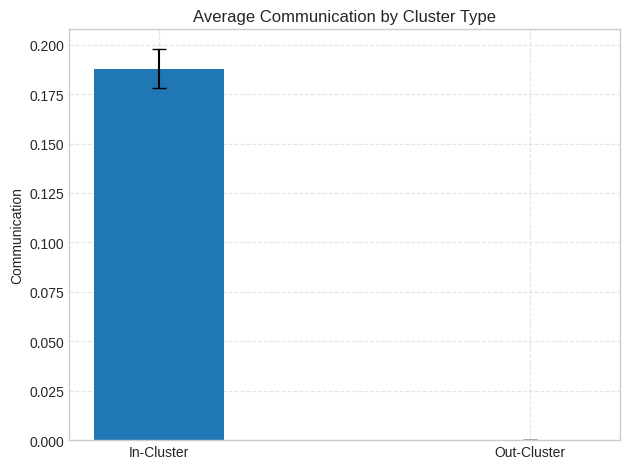

In [17]:
plt.style.use('seaborn-whitegrid')
# Calculate means and standard deviations
in_clus_mean = np.mean(in_clus_ls)
out_clus_mean = np.mean(out_clus_ls)
in_clus_std = np.std(in_clus_ls)
out_clus_std = np.std(out_clus_ls)

# Plotting
labels = ['In-Cluster', 'Out-Cluster']
means = [in_clus_mean, out_clus_mean]
print('means', means)
stds = [in_clus_std, out_clus_std]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, means, width, yerr=stds, label='Mean Communication', capsize=5,
                color=['#1f77b4', '#ff7f0e'])
ax.grid(True, which='major', linestyle='--', alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Communication')
ax.set_title('Average Communication by Cluster Type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
# ax.legend()

# ax.bar_label(rects1, padding=3)
fig.tight_layout()

plt.show()